    Arun Das
    Research Fellow
    Secure AI and Autonomy Laboratory
    University of Texas at San Antonio


# Rotational Invariance in Convolutional Neural Networks

Over the course of history, convolution operation has helped accelerate science and signal processing in a variety of ways. With the advent of deep learning, computer vision researchers began exploring the use of 2D and 3D convolutional neural networks (CNNs) directly on 2D or 3D images to reduce the parameters involved with fully connected deep neural networks. With large amount of data and computation at their disposal, supervised CNN learning algorithms tackled problems which were almost impossible to generalize in the past decade.

CNNs are impressive feature extractors, extracting features heirarchically from the training images during the learning process. First few layers close to the input data learns kernels related to high contrast points, edges, and lines. Layers further in the network learns to map these primitive kernels together to understand countours and other shapes. This heirarchical way of learning by representation enables complex pattern recognition that was impossible using traditional signal processing and machine learning algorithms.

Invariances in input data distribution used for training is mapped in to the CNN as weights, which are infact learned by the kernels. For example, if a face classifier is trained on images with face cropped, aligned, and centered in the center of the image, the CNN will learn to map the input pixels accordingly, and generalize on providing impressive results on faces which are preprocessed and centered properly. However, the interesting question arises on the robustness of CNNs on slighly invariant input images which are from outside the data distribution. This is where our discussion on rotational invariance starts - and in my opinion, the many questions we ask are translated from this bigger topic of robustness and safe artificial intelligence (AI).

<h2><center>How to follow this blog/report series</h2></center>

I am planning to tackle this problem of rotational invariance in 3 or 4 parts. The first part, which is this post, will cover some of the early work and foundation that we need to set up to further our research and understanding. This involves coding the CNNs, writing some generic functions to visualize the weights and activations of the CNN. We will focus on creating an easily modifiable CNN architecture so that we can add or remove layers at ease. Inorder to study rotational invariance, we must be able to rotate our training and testing data by a specific angle. Unfortunately, I didn't find a preprocessor that does that in pytorch, which works well with pytorch `transform.compose` functionalities. Hence, we will spend some time creating a custom rotation function that allows us to create training and testing data rotated at our convenience. Also, we will see how we can write a model weight and actication visualization function, that can take any kernel and output the visualizations automatically. Let me break it down below:
    
    Part 1: 
        a. Model definitions
        b. Custom rotation function
        c. Custom weight and activation visualization function
        d. Research leading to part 2: Train on 0 degree and 90 degree images separately. 
           Test mixed. Are there any correlations, change in accuracy, or difference 
           in kernels and activations?
    Part 2:
        a. Double down on weights. What are the fundamental differences in the 
           weights learned?
        b. Double down on activations. Do you find any significant changes? 
           Are there something popping out to you? Something obvious?
        c. What happens if I add another CONV layer, maxpool, or other layers?
        ...
    ...

<h2><center>Rotational Invariance in CNNs - Part 1</h2></center>

Let's start coding right away. First goal is to define the models and train one with pure MNIST dataset -> Rotation = $0^o$.

### Import Libraries

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math

### Define the hyperparameters

We define the hyperparameters as keys in an `args` dictionary. This way, it is easy to add and remove hyperparameters, and also to use them.

In [2]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=20  # The number of Epochs is the number of times you go 
                   # through the full dataset. 
args['lr']=0.01 # Learning rate is how fast it will decend. 
args['momentum']=0.5 # SGD momentum (default: 0.5) Momentum is a moving 
                     # average of our gradients (helps to keep direction).

args['seed']=1 # random seed
args['log_interval']=40
args['cuda']=True # False if you don't have a CUDA w/ NVIDIA GPU available.
args['train_now']=False

### Define custom rotation function

In [3]:
class CustomRotation(object):
    """Rotate image by a fixed angle which is ready for tranform.Compose()
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center

    def __call__(self, img):
        
        return transforms.ToTensor()(
            transforms.functional.rotate(
                transforms.ToPILImage()(img), 
                self.degrees, self.resample, self.expand, self.center))

### Define data loaders

In [4]:
rotation = 0 # Specifies the rotation of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomRotation(rotation),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomRotation(rotation),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

### Define the CNN model 

We'll gracefully build upon existing OOP paradigms and define the CNN as a Class. Later, we could change the layers and configurations the way we want. This is our base class for the CNN model.

In [5]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        # These are all operations that we are defining.
        # Unlike keras, this is not the network definition.
        # This is just initialization of the variables that 
        # we are going to use in the `forward()` function.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d()  
        # https://pytorch.org/docs/stable/nn.html#dropout2d 
        # If adjacent pixels within feature maps are strongly correlated 
        # (as is normally the case in early convolution layers) then 
        # i.i.d. dropout will not regularize the activations and will 
        # otherwise just result in an effective learning rate decrease. 
        # In this case, nn.Dropout2d() will help promote independence 
        # between feature maps and should be used instead.
        
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3)
        self.conv4 = nn.Conv2d(40, 40, kernel_size=3)
        
        self.conv4_drop = nn.Dropout2d()
        
        # Fix the number of neurons in the linear (fully connected) 
        # layer by studying x.shape[1]*x.shape[2]*x.shape[3] in 
        # the `forward()` function.
        self.fc1 = nn.Linear(40, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(
            F.max_pool2d(
                self.conv1(x), 2)) # stride of 2 for max pool
        x = F.relu(
                self.conv2_drop(
                    self.conv2(x)))
        x = F.relu(
            F.max_pool2d(
                self.conv3(x), 2))
        x = F.relu(
                self.conv4_drop(
                    self.conv4(x)))
        # Since input dimensions to the fully connected
        # layer is set as 80 in the init function
        # above, we have to reshape the CONV output to reflect that.
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        # Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # Fully Connected Layer/Activation
        x = self.fc2(x)
        # Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

In [6]:
model = Net()
if args['cuda']:
    model.cuda()

In [7]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Conv2d-4             [-1, 40, 6, 6]           7,240
            Conv2d-5             [-1, 40, 1, 1]          14,440
         Dropout2d-6             [-1, 40, 1, 1]               0
            Linear-7                   [-1, 20]             820
            Linear-8                   [-1, 10]             210
Total params: 27,990
Trainable params: 27,990
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.11
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


We will write functions to train and test the model we created above. Here, we are taking the defined `model` variable as a global variable. Hence, we use it directly within the function, and doesn't pass it as an argument to the function. This helps in updating model parameters easily, but could be made better by adding model as a parameter to the function and thinking about ways to make it a global variable accessible from anywhere.

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Train the CNN model on normal MNIST images

We'll use stocastic gradient descend (SGD) as the optimizer and use momentum to lead the way. The hyperparameters are passed using `args` dictionary and the required key.

In [9]:
optimizer = optim.SGD(model.parameters(), 
                      lr=args['lr'], momentum=args['momentum'])

# Training loop. 
# Change `args['log_interval']` if you want to change logging behavior.
# We test the network in each epoch.
# Setting the bool `args['train_now']` to not run training all the time.
# We'll save the weights and use the saved weights instead of 
# training the network everytime we load the jupyter notebook.

if args['train_now']:
    for epoch in range(1, args['epochs'] + 1):
        train(epoch)
        test()
    torch.save(model.state_dict(), 'models/model_normal_mnist.pytrh')
else:
    model = Net()
    if args['cuda']:
        device = torch.device("cuda")
        model.load_state_dict(torch.load('models/model_normal_mnist.pytrh'))
        model.to(device)
    else:
        model.load_state_dict(torch.load('models/model_normal_mnist.pytrh'))
    model.eval()

## Kernel weight visualizations

Inorder to understand how the network learns, it is not only important to log the training and testing accuracies but also to visualize what the network learns. As we get over the deep learning hype, we should invest time in learning the intricate features which makes these networks what they are. As a first step, we shall write a custom visualization function to plot the kernels and activations of the CNN - whatever the size. This is a key piece of code that will drive us forward and unfortunately isn't available in Pytorch or internet :) So custom indeed.

In [10]:
def custom_viz(kernels, path=None, cols=None):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,
    # plot them in a row.
    # Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)
    
    plt.show()

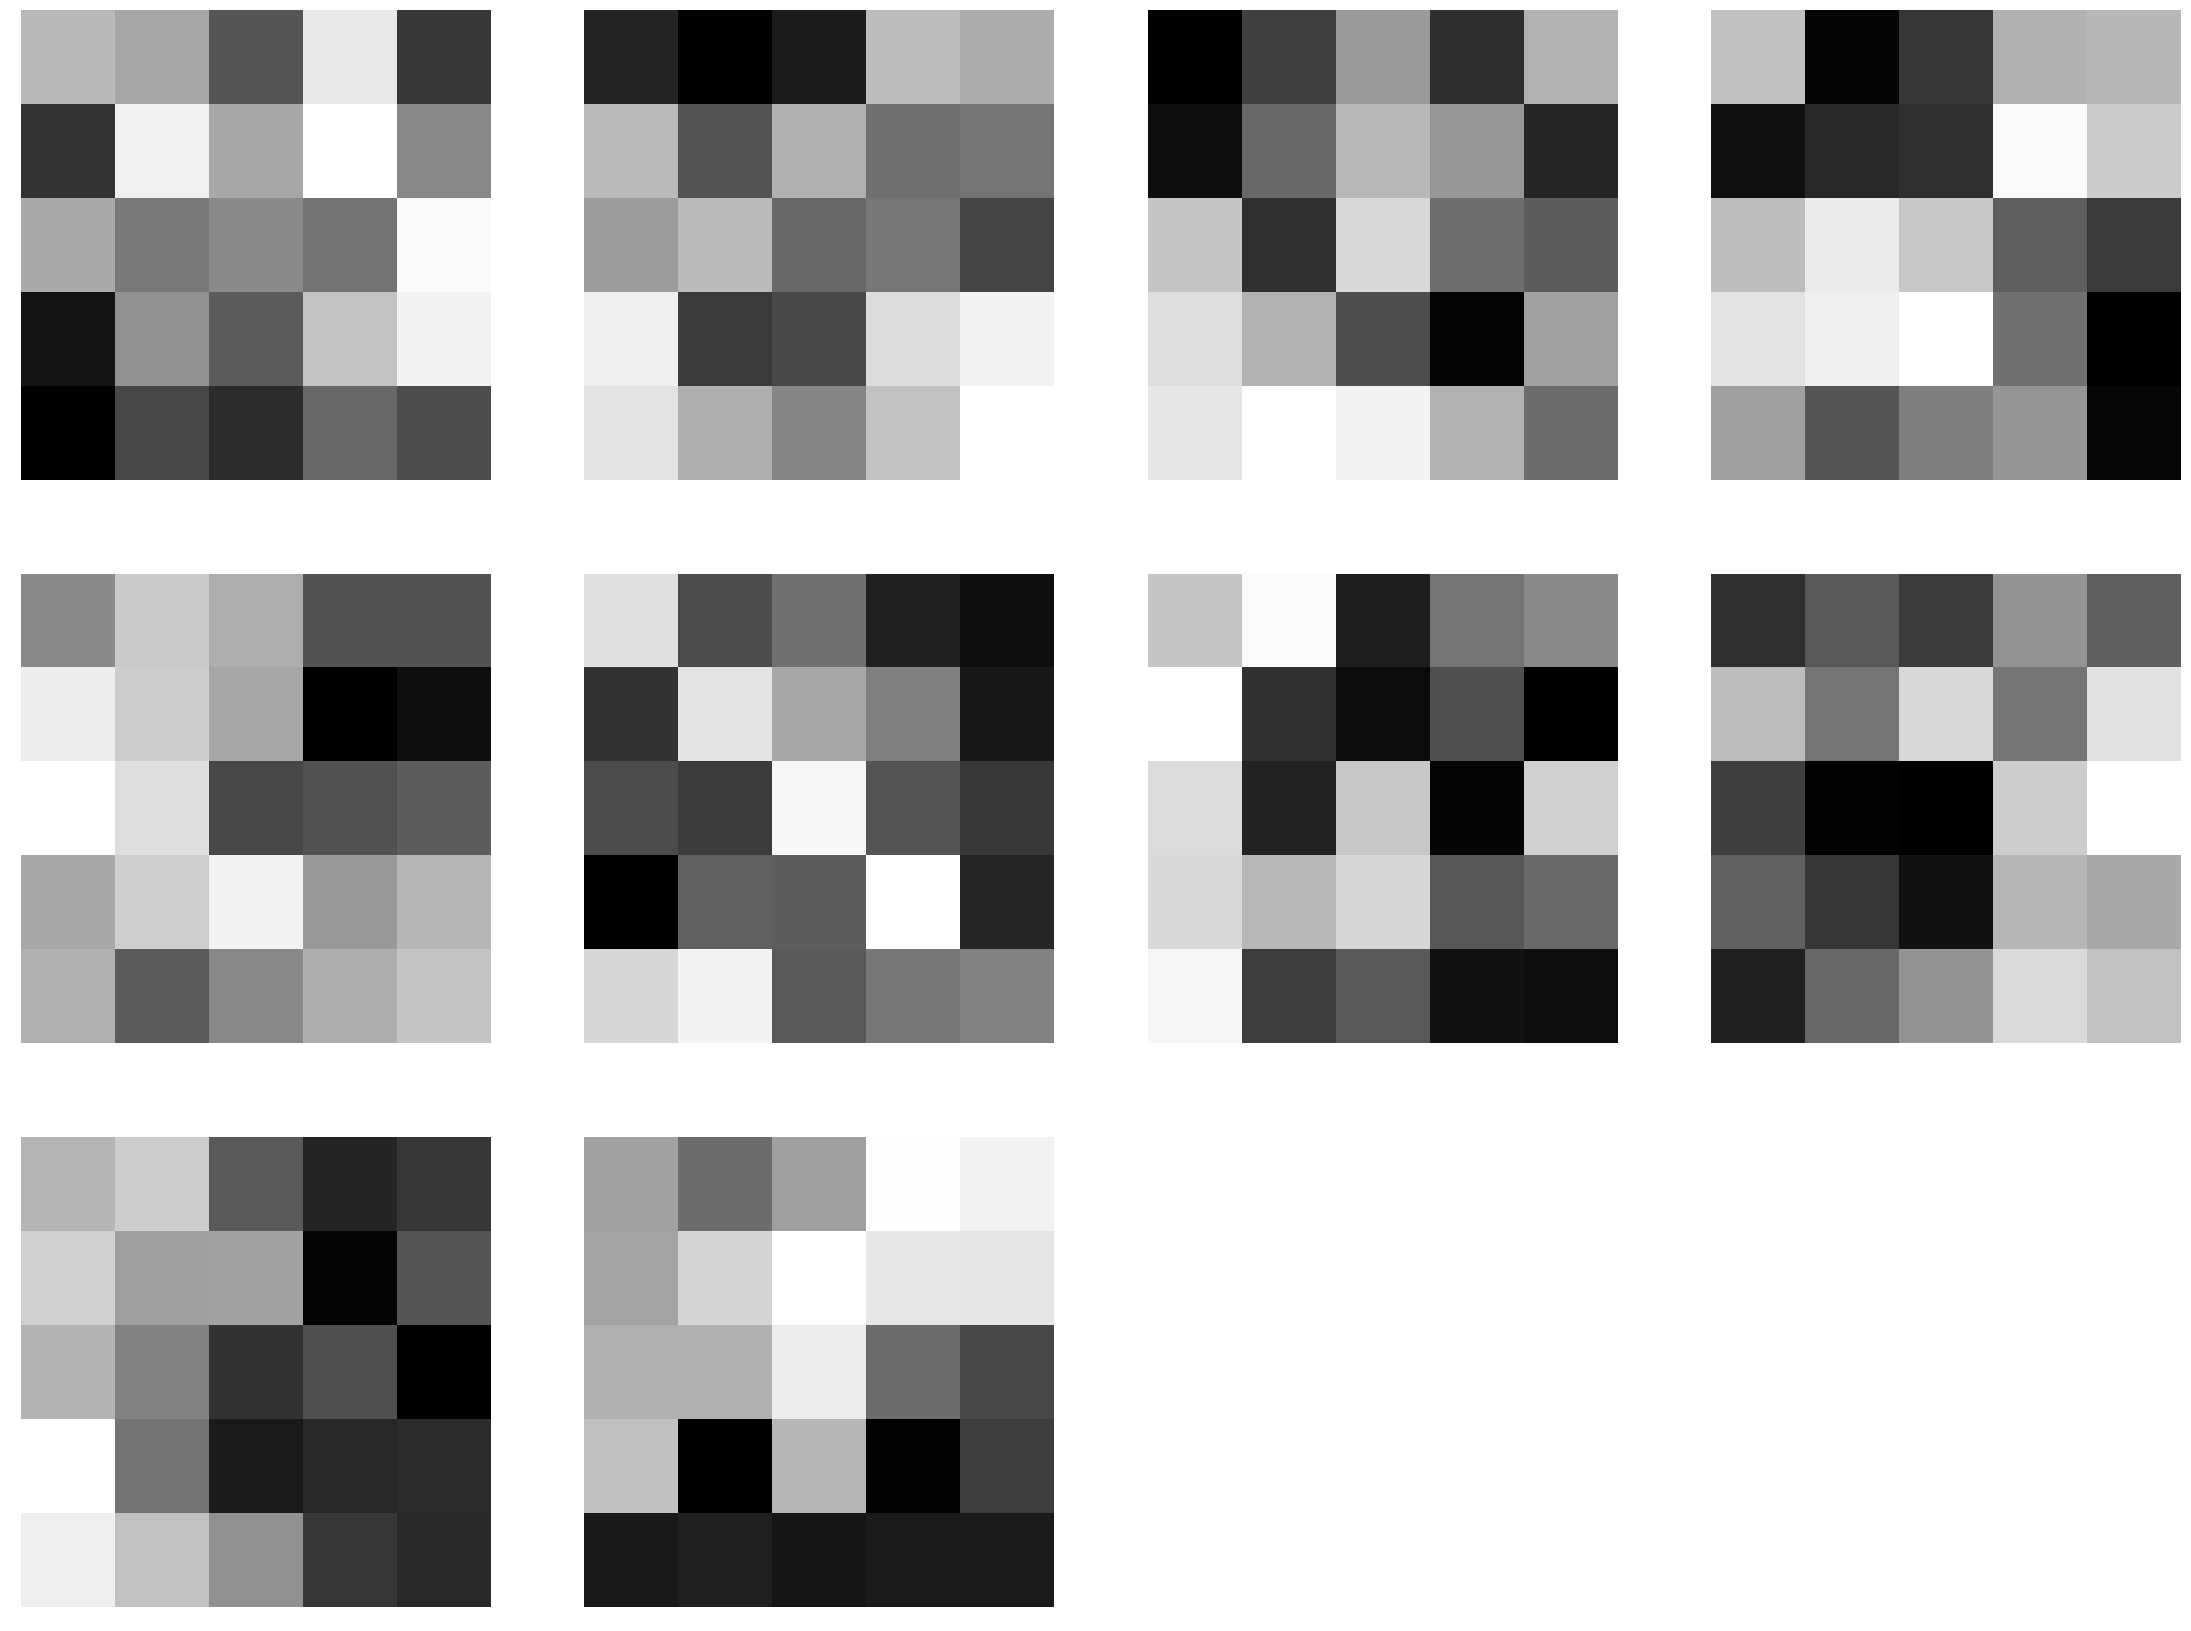

In [11]:
kernels = model.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv1_weights.png', 4)

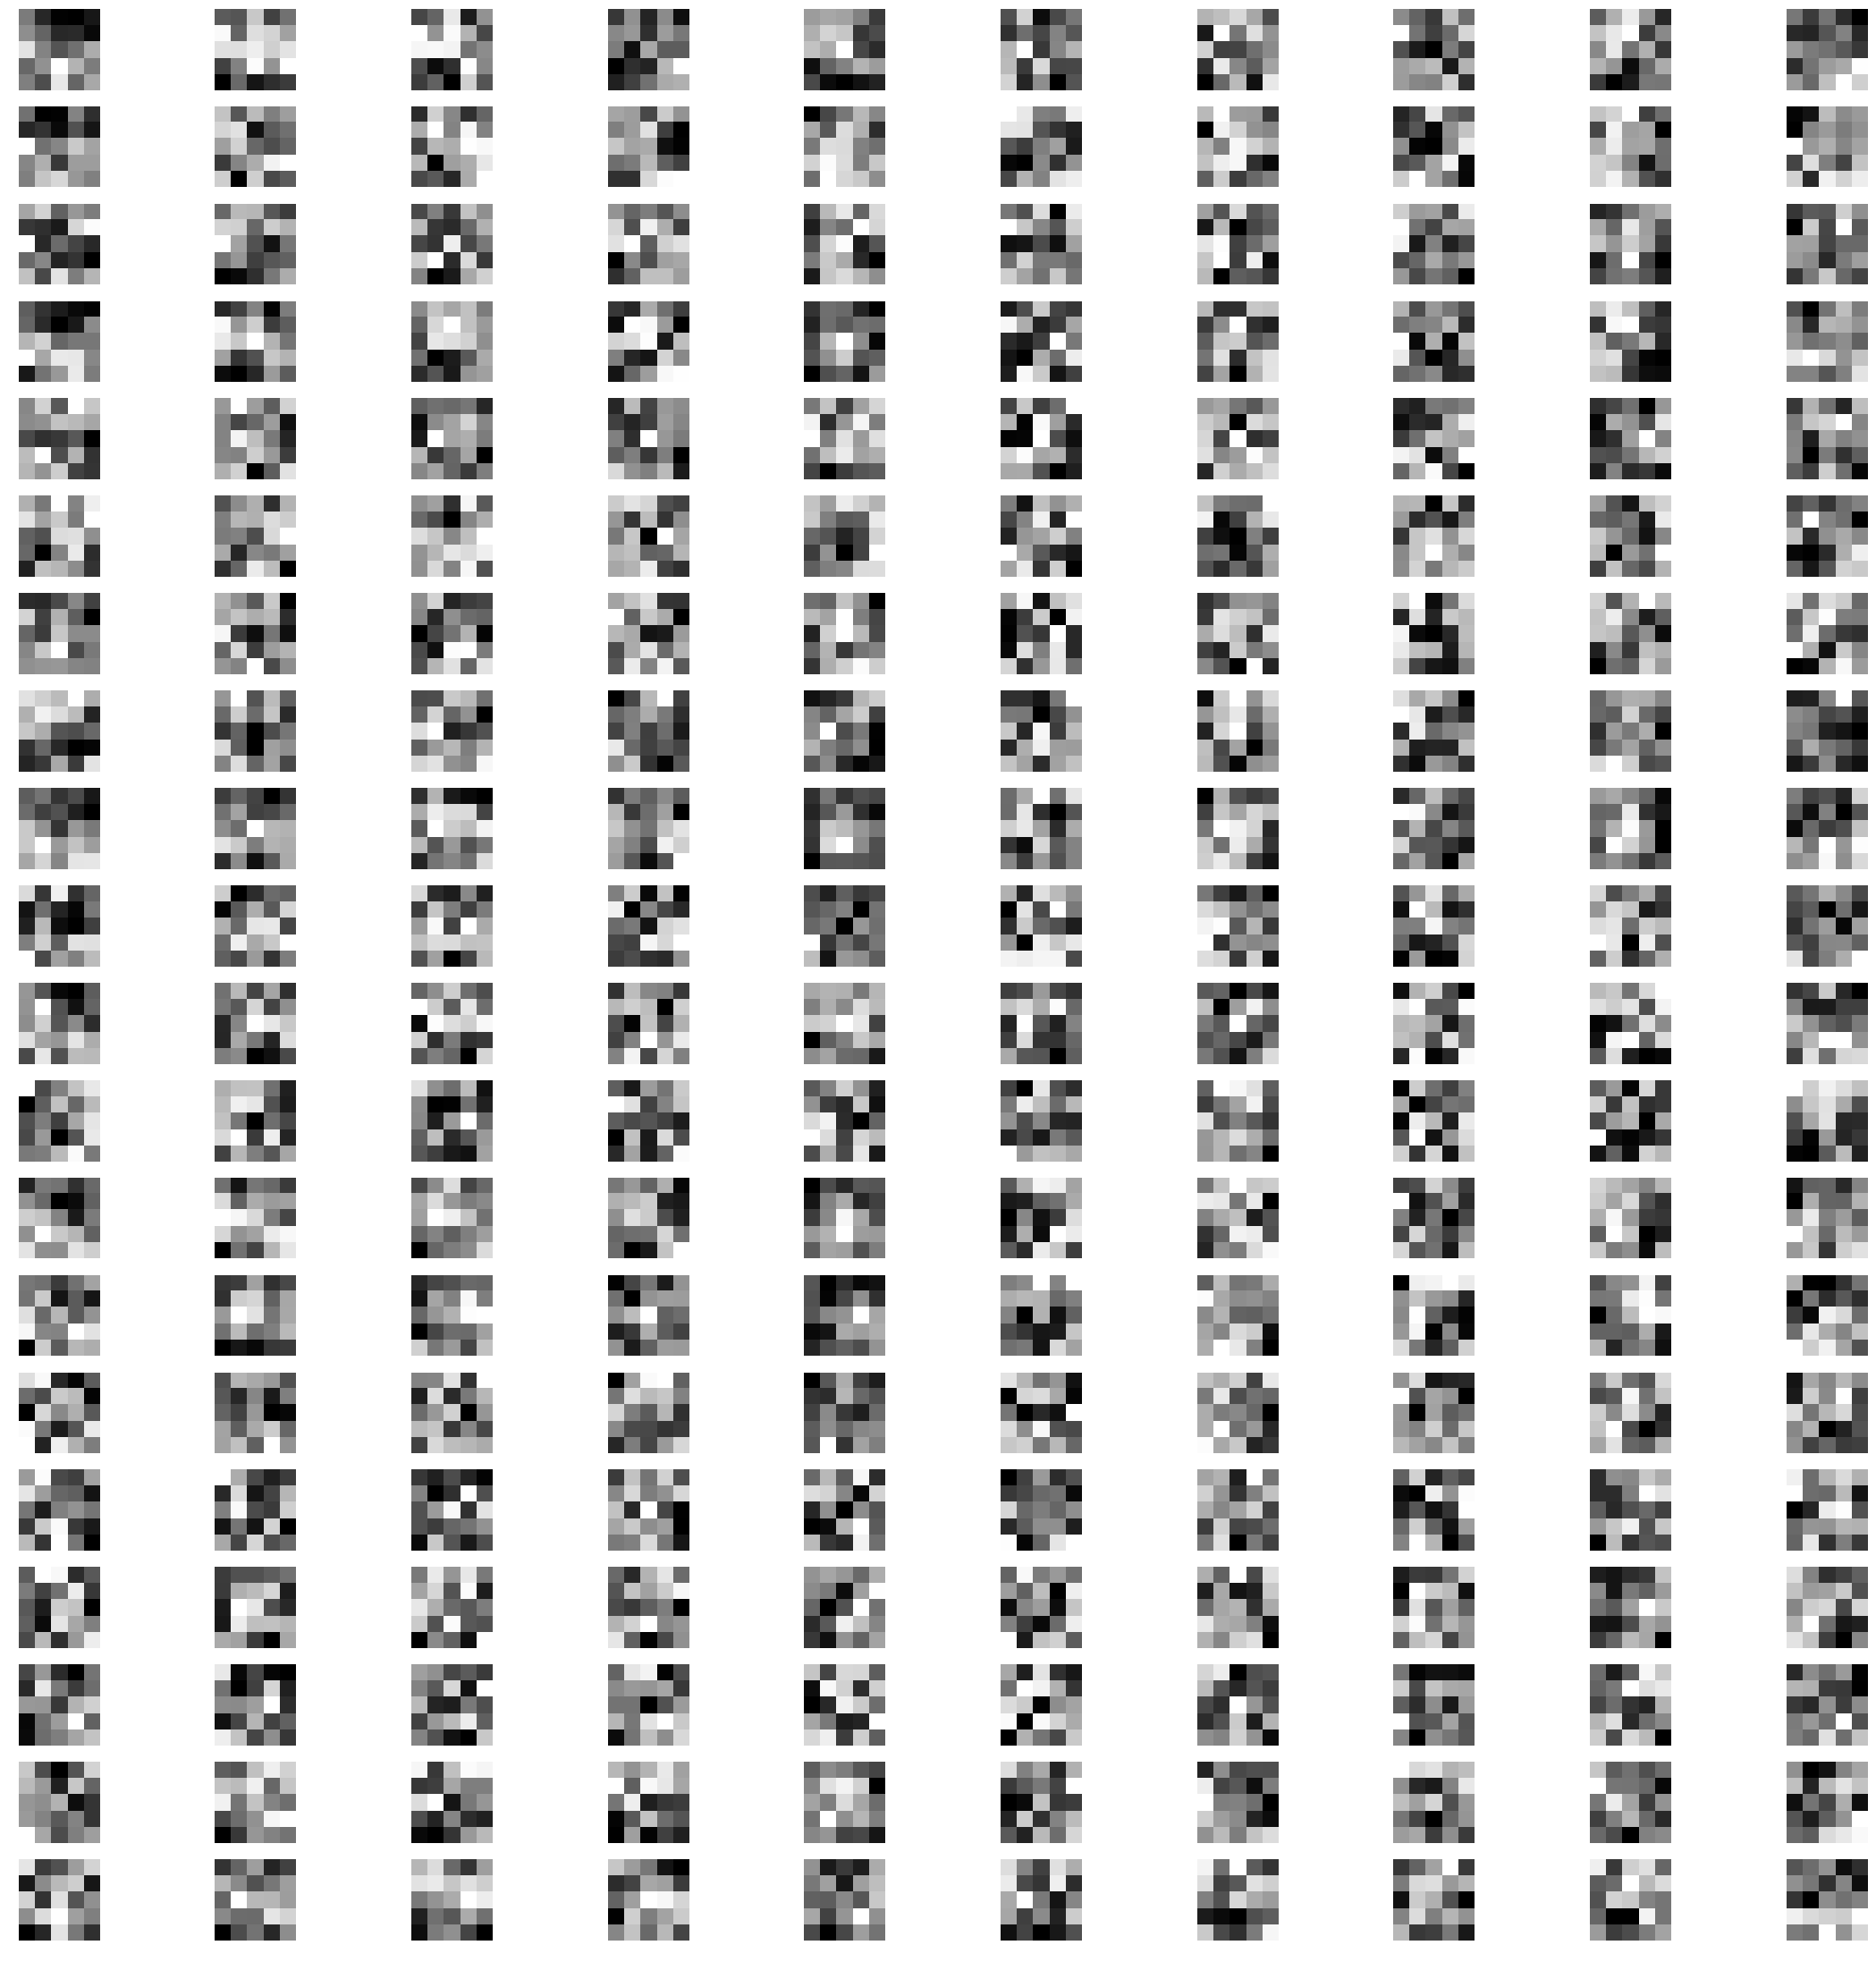

In [12]:
kernels = model.conv2.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv2_weights.png', cols=5)

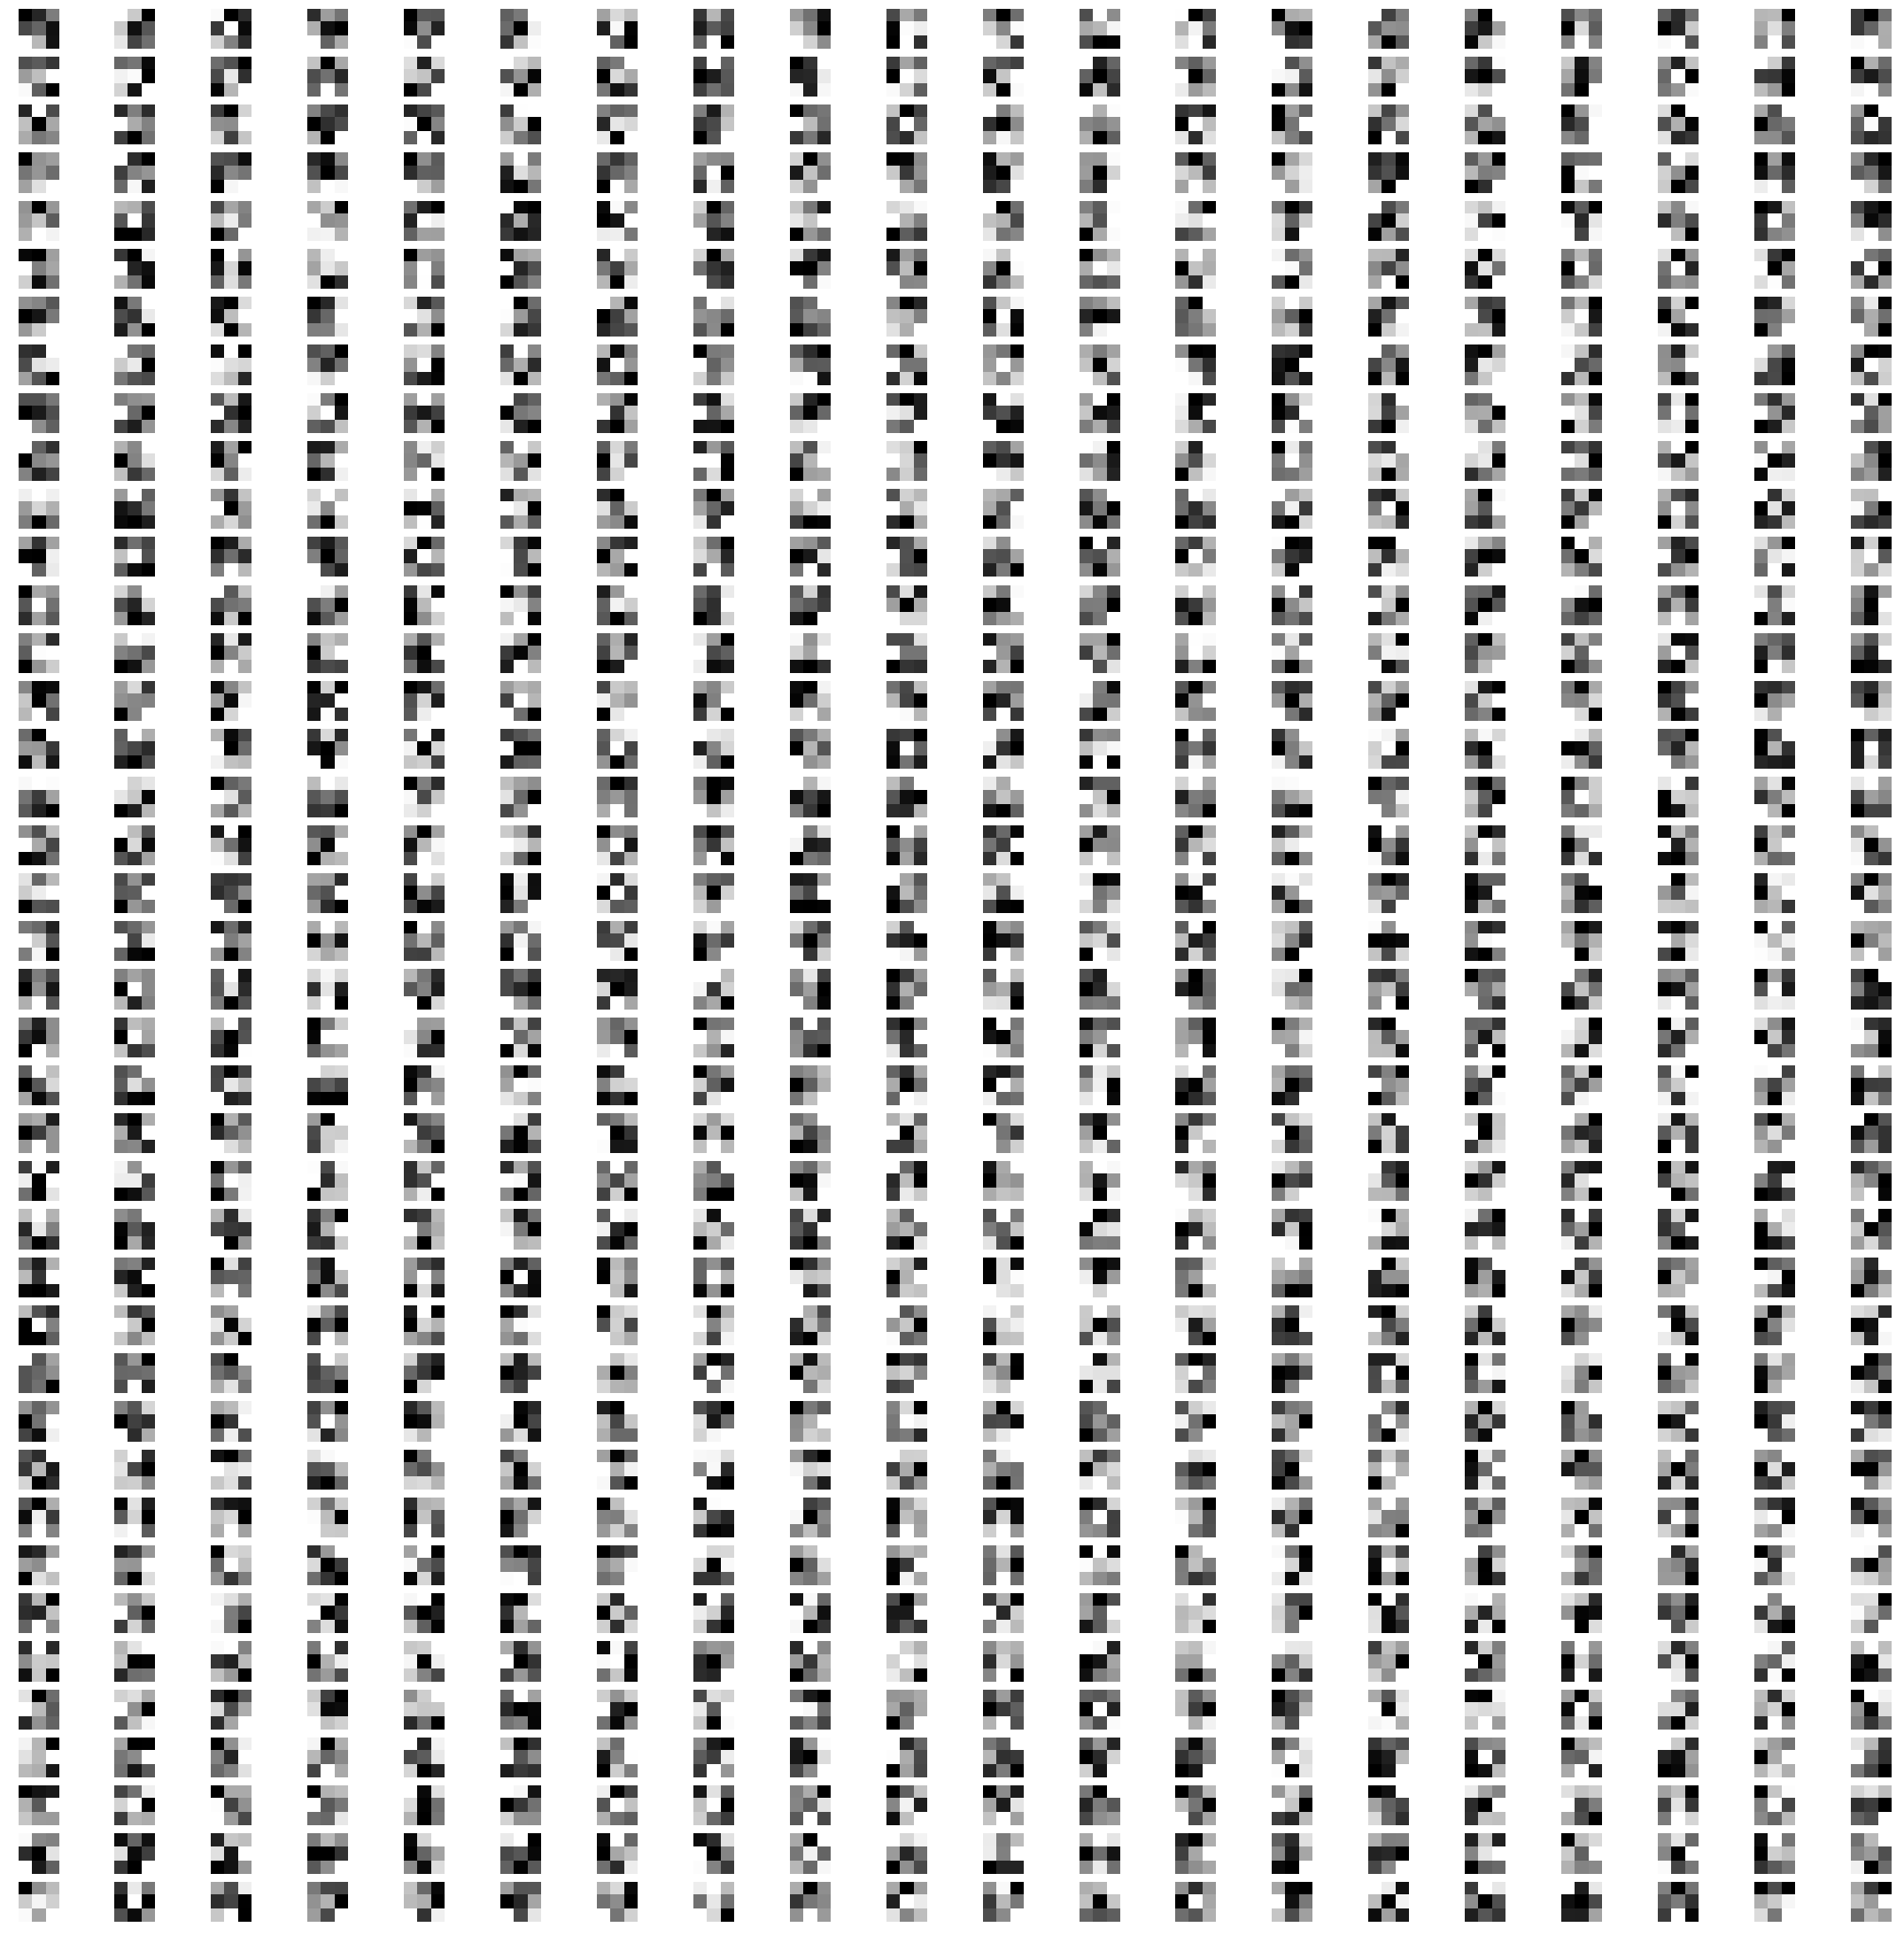

In [13]:
kernels = model.conv3.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv3_weights.png')

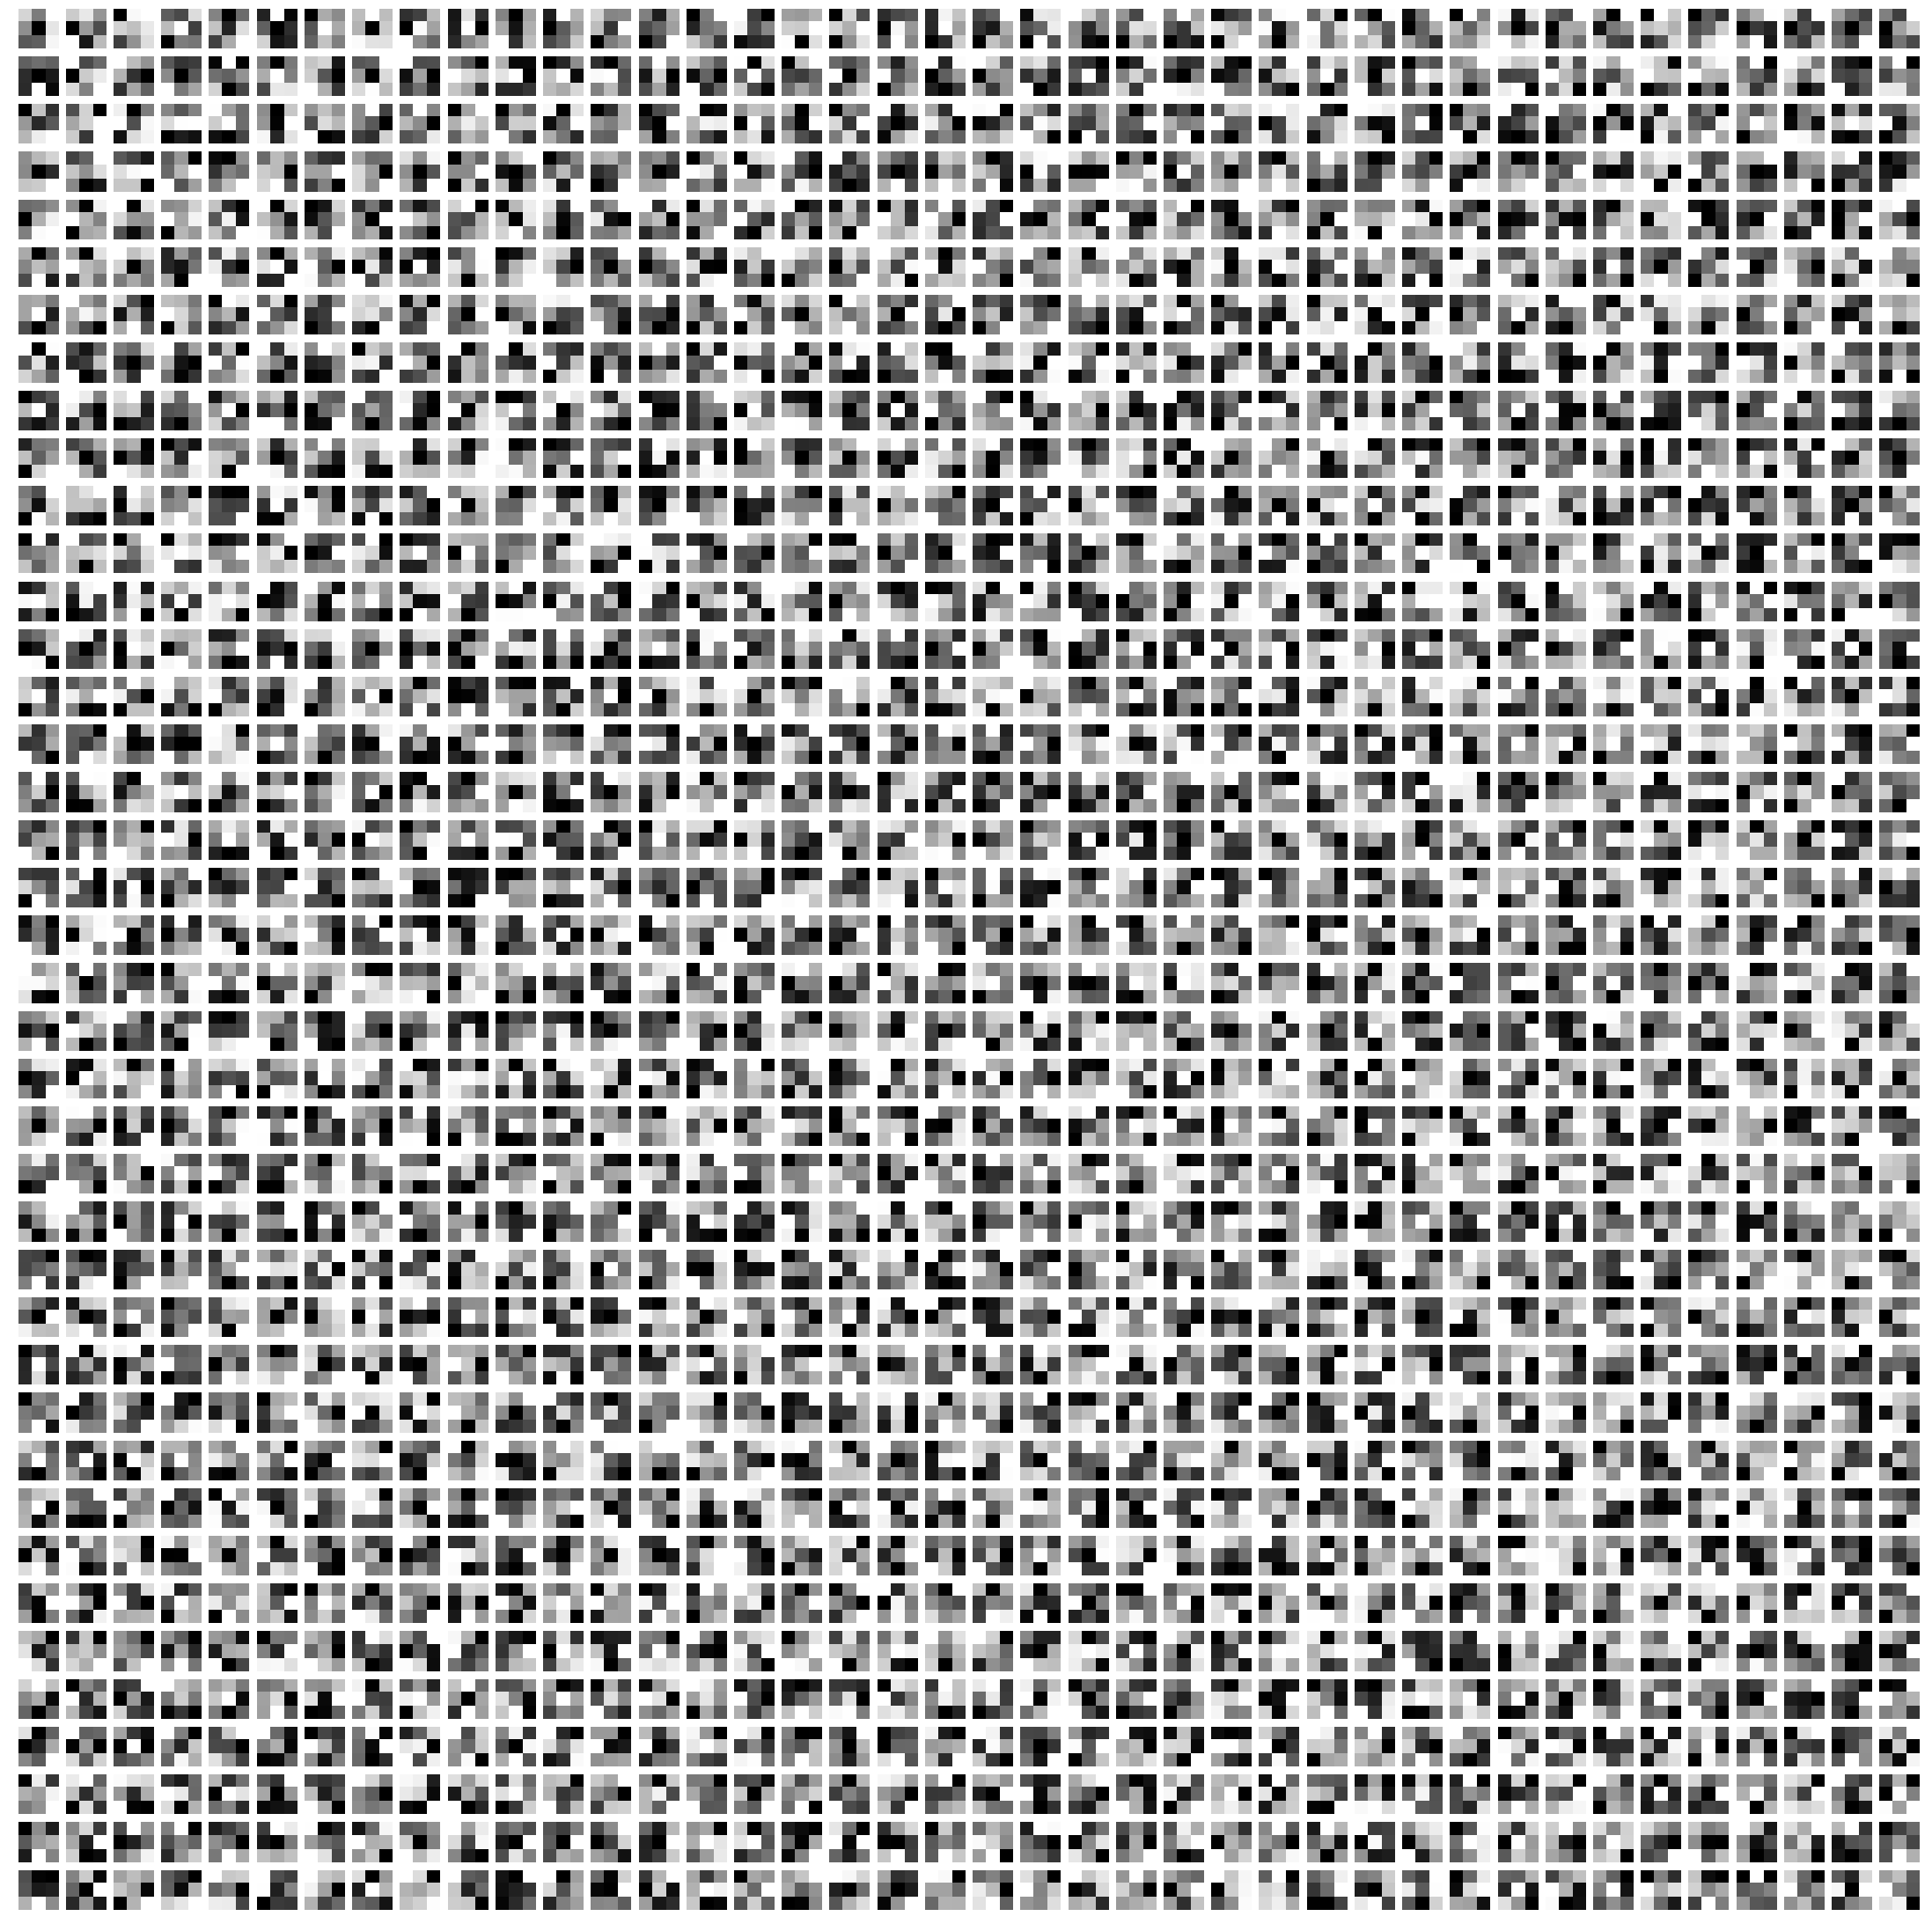

In [14]:
kernels = model.conv4.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv4_weights.png')

## Activation Visualization

In [15]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [16]:
def rotate_tensor(_in_tensor, plot=True):
    in_tensor = _in_tensor.clone()
    # Add one more channel to the beginning. Tensor shape = 1,1,28,28
    in_tensor.unsqueeze_(0)
    # Convert to Pytorch variable
    in_tensor = Variable(in_tensor, requires_grad=True)
    
    in_tensor_90 = in_tensor.transpose(2, 3).flip(3)
    in_tensor_180 = in_tensor.flip(2).flip(3)
    in_tensor_270 = in_tensor.transpose(2, 3).flip(2)
    
    if plot:
        plt.figure(1)
        plt.subplot(221)
        plt.gca().set_title('0 degree')
        plt.imshow(in_tensor[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(222)
        plt.gca().set_title('+90 degree')
        plt.imshow(in_tensor_90[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(223)
        plt.gca().set_title('+270 degree')
        plt.imshow(in_tensor_270[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(224)
        plt.gca().set_title('+180 degree')
        plt.imshow(in_tensor_180[0][0].cpu().detach().clone(), cmap='gray')
        plt.tight_layout()
        plt.show()
    return(in_tensor, in_tensor_90, in_tensor_180, in_tensor_270)

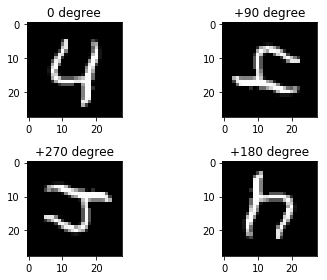

In [17]:
number, number_90, number_180, number_270 = rotate_tensor(example_data[4])

In [18]:
print("Predicted Class: ", 
      np.argmax(model.forward(number.cuda()).cpu().detach().numpy()))

Predicted Class:  4


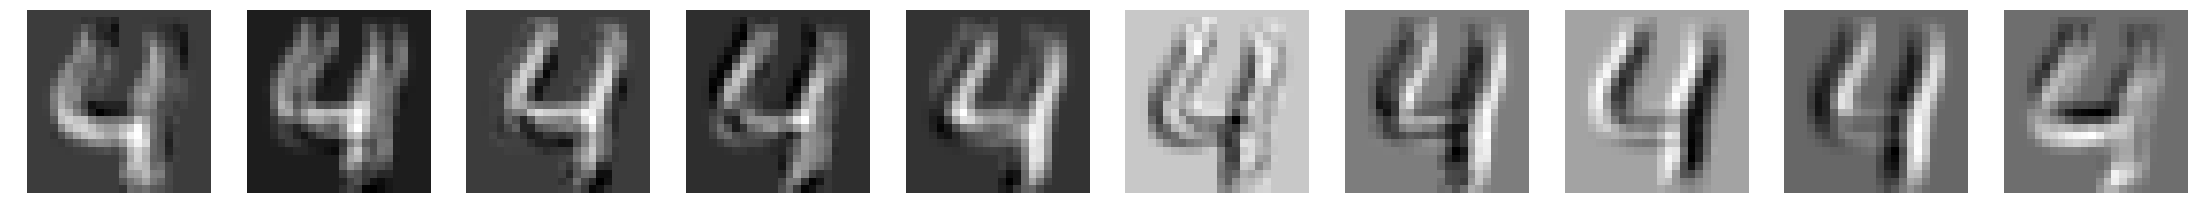

In [19]:
conv1_out = model.conv1.forward(number.cuda())
custom_viz(conv1_out.cpu().detach().clone(), 'results/conv1_actv.png')

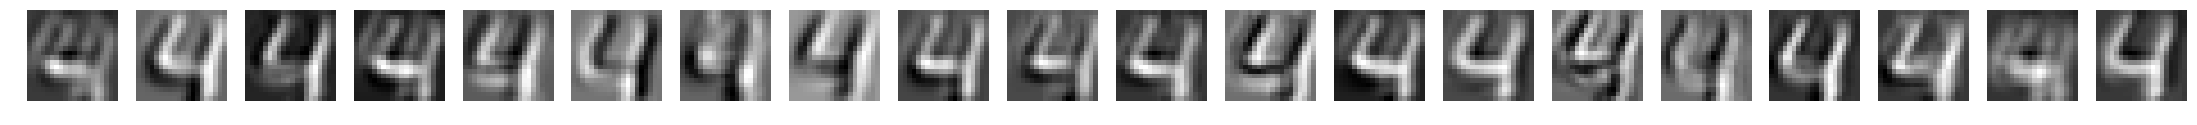

In [20]:
conv2_out = model.conv2.forward(conv1_out.cuda())
custom_viz(conv2_out.cpu().detach().clone(), 'results/conv2_actv.png')

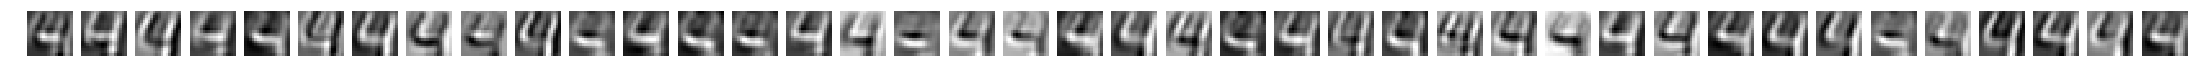

In [21]:
conv3_out = model.conv3.forward(conv2_out.cuda())
custom_viz(conv3_out.cpu().detach().clone(), 'results/conv3_actv.png')

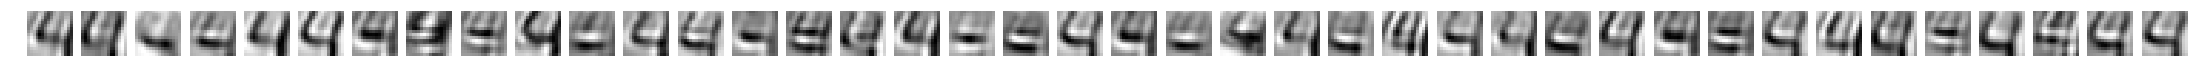

In [22]:
conv4_out = model.conv4.forward(conv3_out.cuda())
custom_viz(conv4_out.cpu().detach().clone(), 'results/conv4_actv.png')

# Study +90 degree rotation on MNIST

In [23]:
# Specify the rotation
rotation = 90

# Load the data
train_loader_90 = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       CustomRotation(rotation),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)


test_loader_90 = torch.utils.data.DataLoader(
datasets.MNIST('data/', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    CustomRotation(rotation),
    transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

# Get some example data from test loader
examples_90 = enumerate(test_loader_90)
batch_idx, (example_data_90, example_targets_90) = next(examples_90)

In [24]:
# Specify and account for GPU usage
model_90 = Net()
if args['cuda']:
    model_90.cuda()

In [25]:
# Define train and test functions as before. 
# TODO: Consider adding model as an argument.

def train_90(epoch):
    model_90.train()
    for batch_idx, (data, target) in enumerate(train_loader_90):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model_90(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_90.dataset),
                100. * batch_idx / len(train_loader_90), loss.data))

def test_90():
    model_90.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader_90:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model_90(data)
        # sum up batch loss # size_average and reduce args will be 
        # deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader_90.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader_90.dataset),
        100. * correct / len(test_loader_90.dataset)))

In [26]:
# Define optimizer and train the model.
# If the model is already trained, try to load the model.
# Will give an error if trained model doesn't exist.

optimizer = optim.SGD(model_90.parameters(), 
                      lr=args['lr'], momentum=args['momentum'])

if args['train_now']:
    for epoch in range(1, args['epochs'] + 1):
        train_90(epoch)
        test_90()
    torch.save(model_90.state_dict(), 'models/model_90_mnist.pytrh')
else:
    model_90 = Net()
    if args['cuda']:
        device = torch.device("cuda")
        model_90.load_state_dict(torch.load('models/model_90_mnist.pytrh'))
        model_90.to(device)
    else:
        model_90.load_state_dict(torch.load('models/model_90_mnist.pytrh'))
    model_90.eval()

## Kernel Weight Visualization

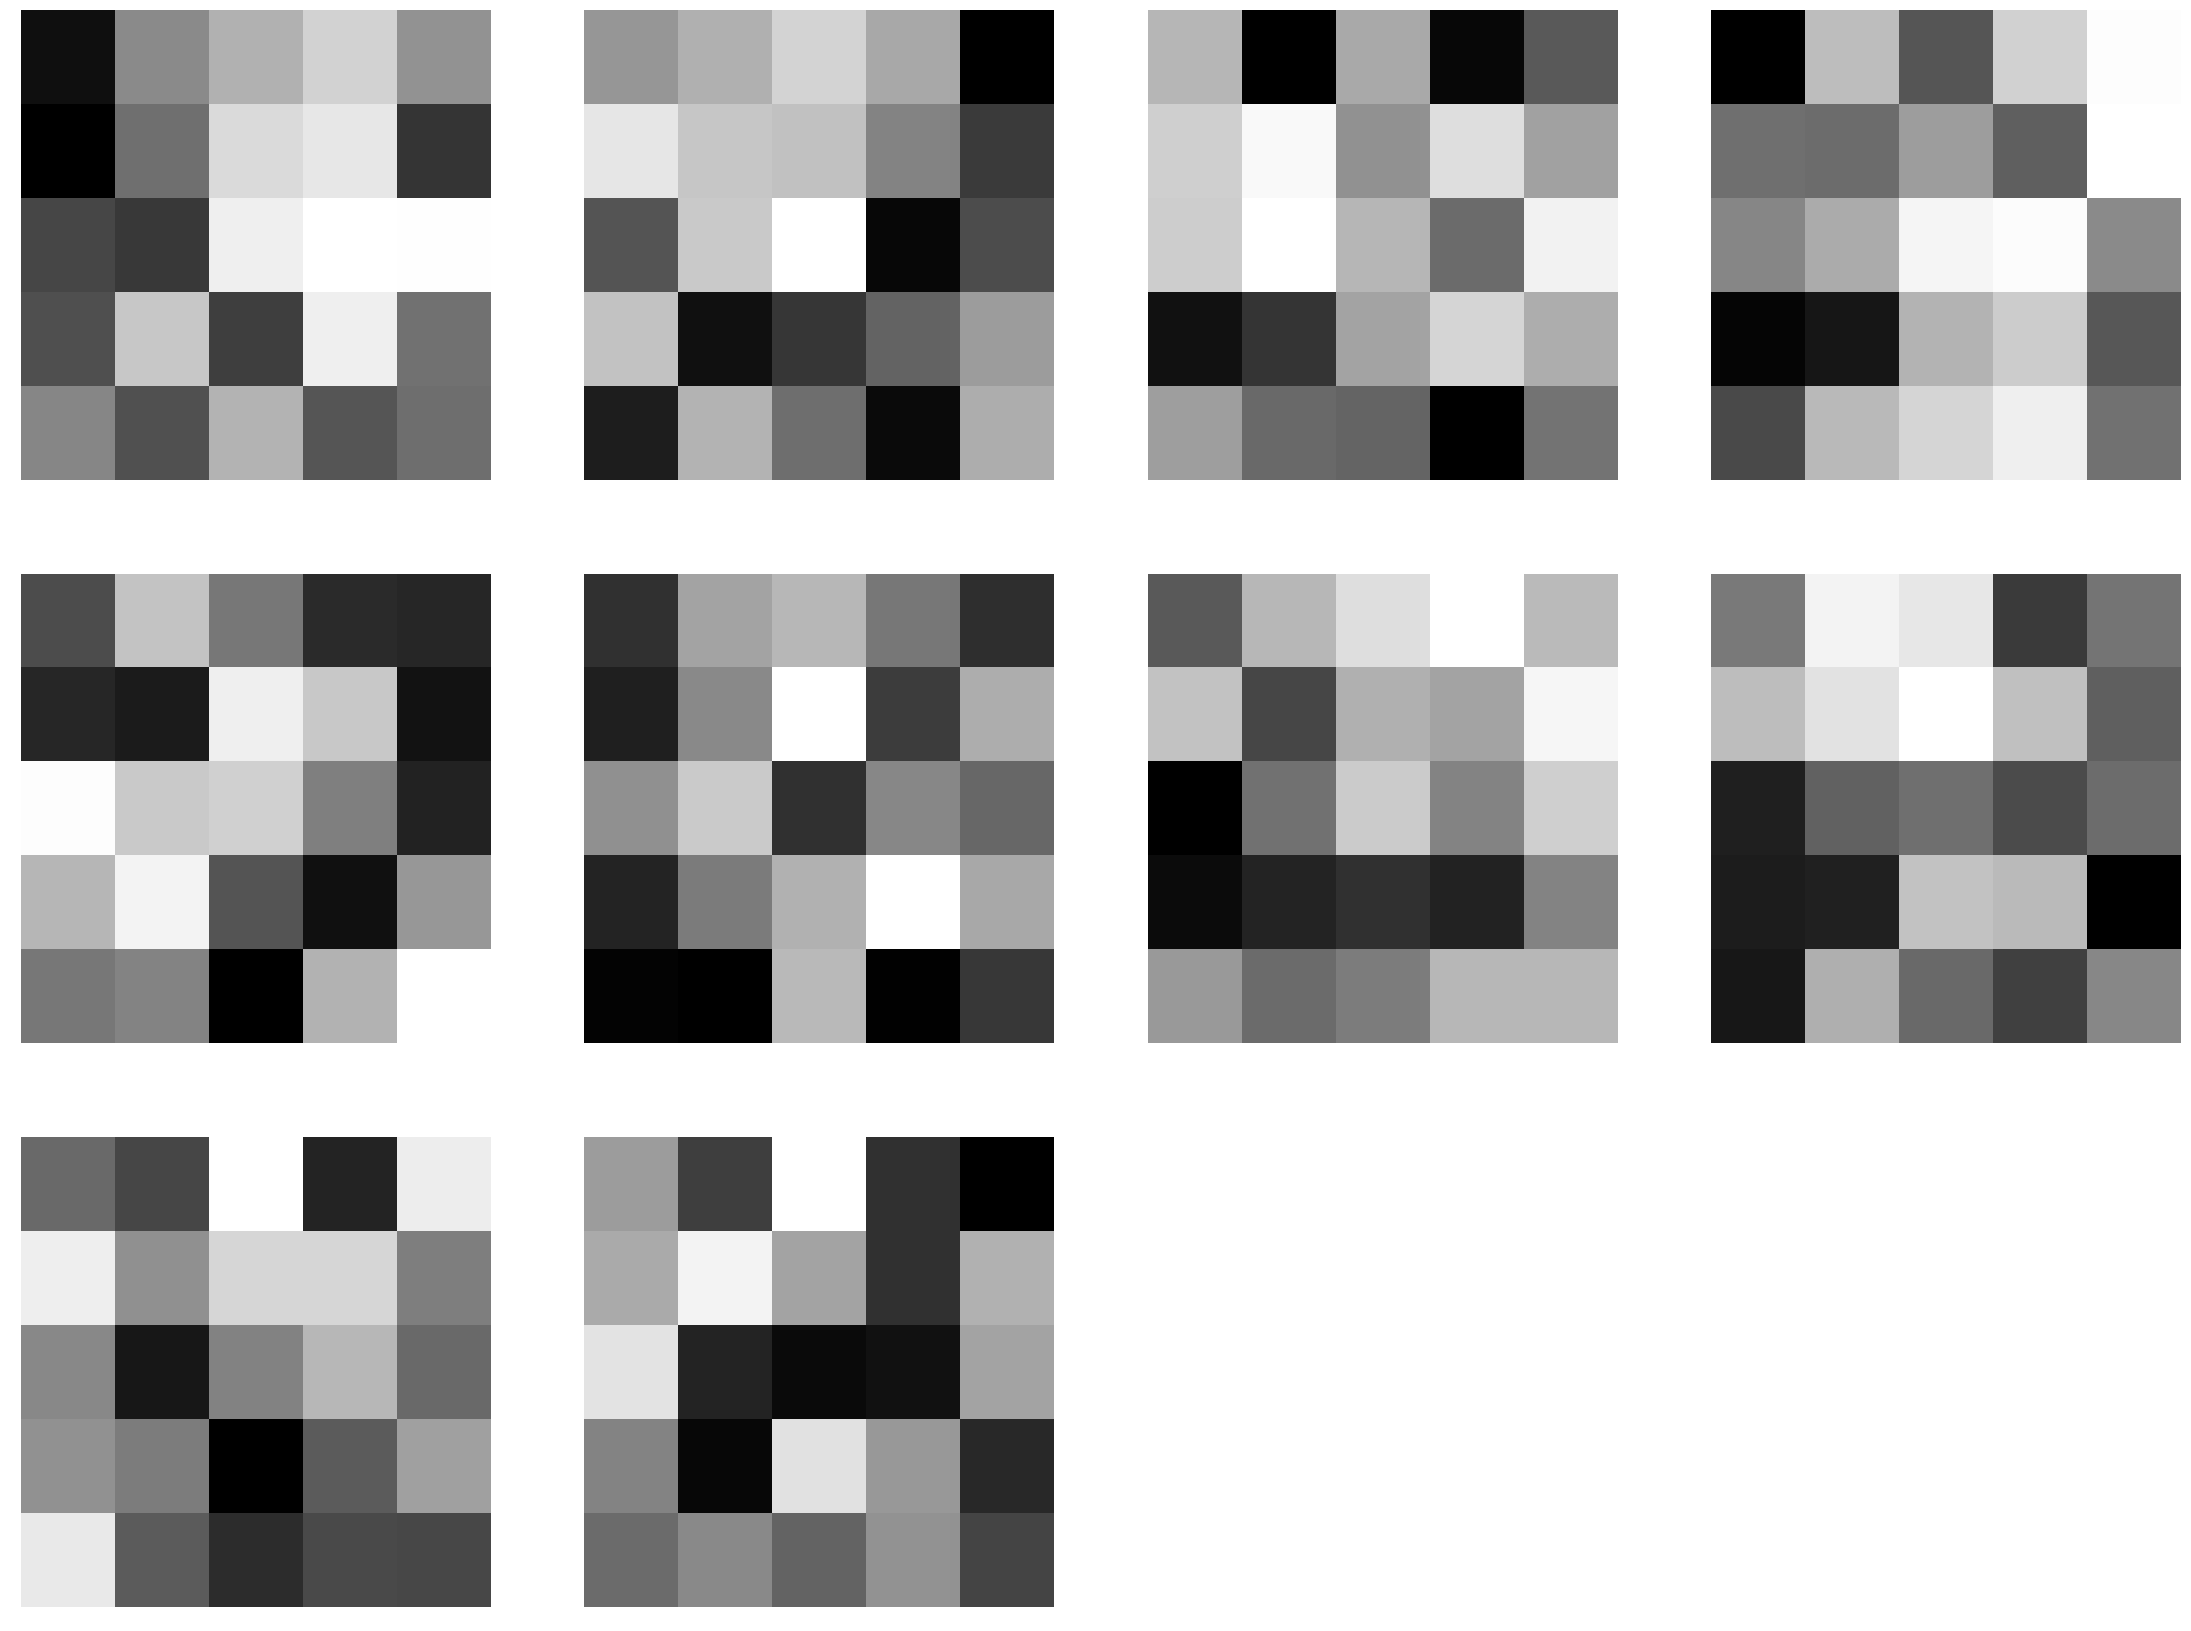

In [27]:
kernels = model_90.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv1_weights_90.png', 4)

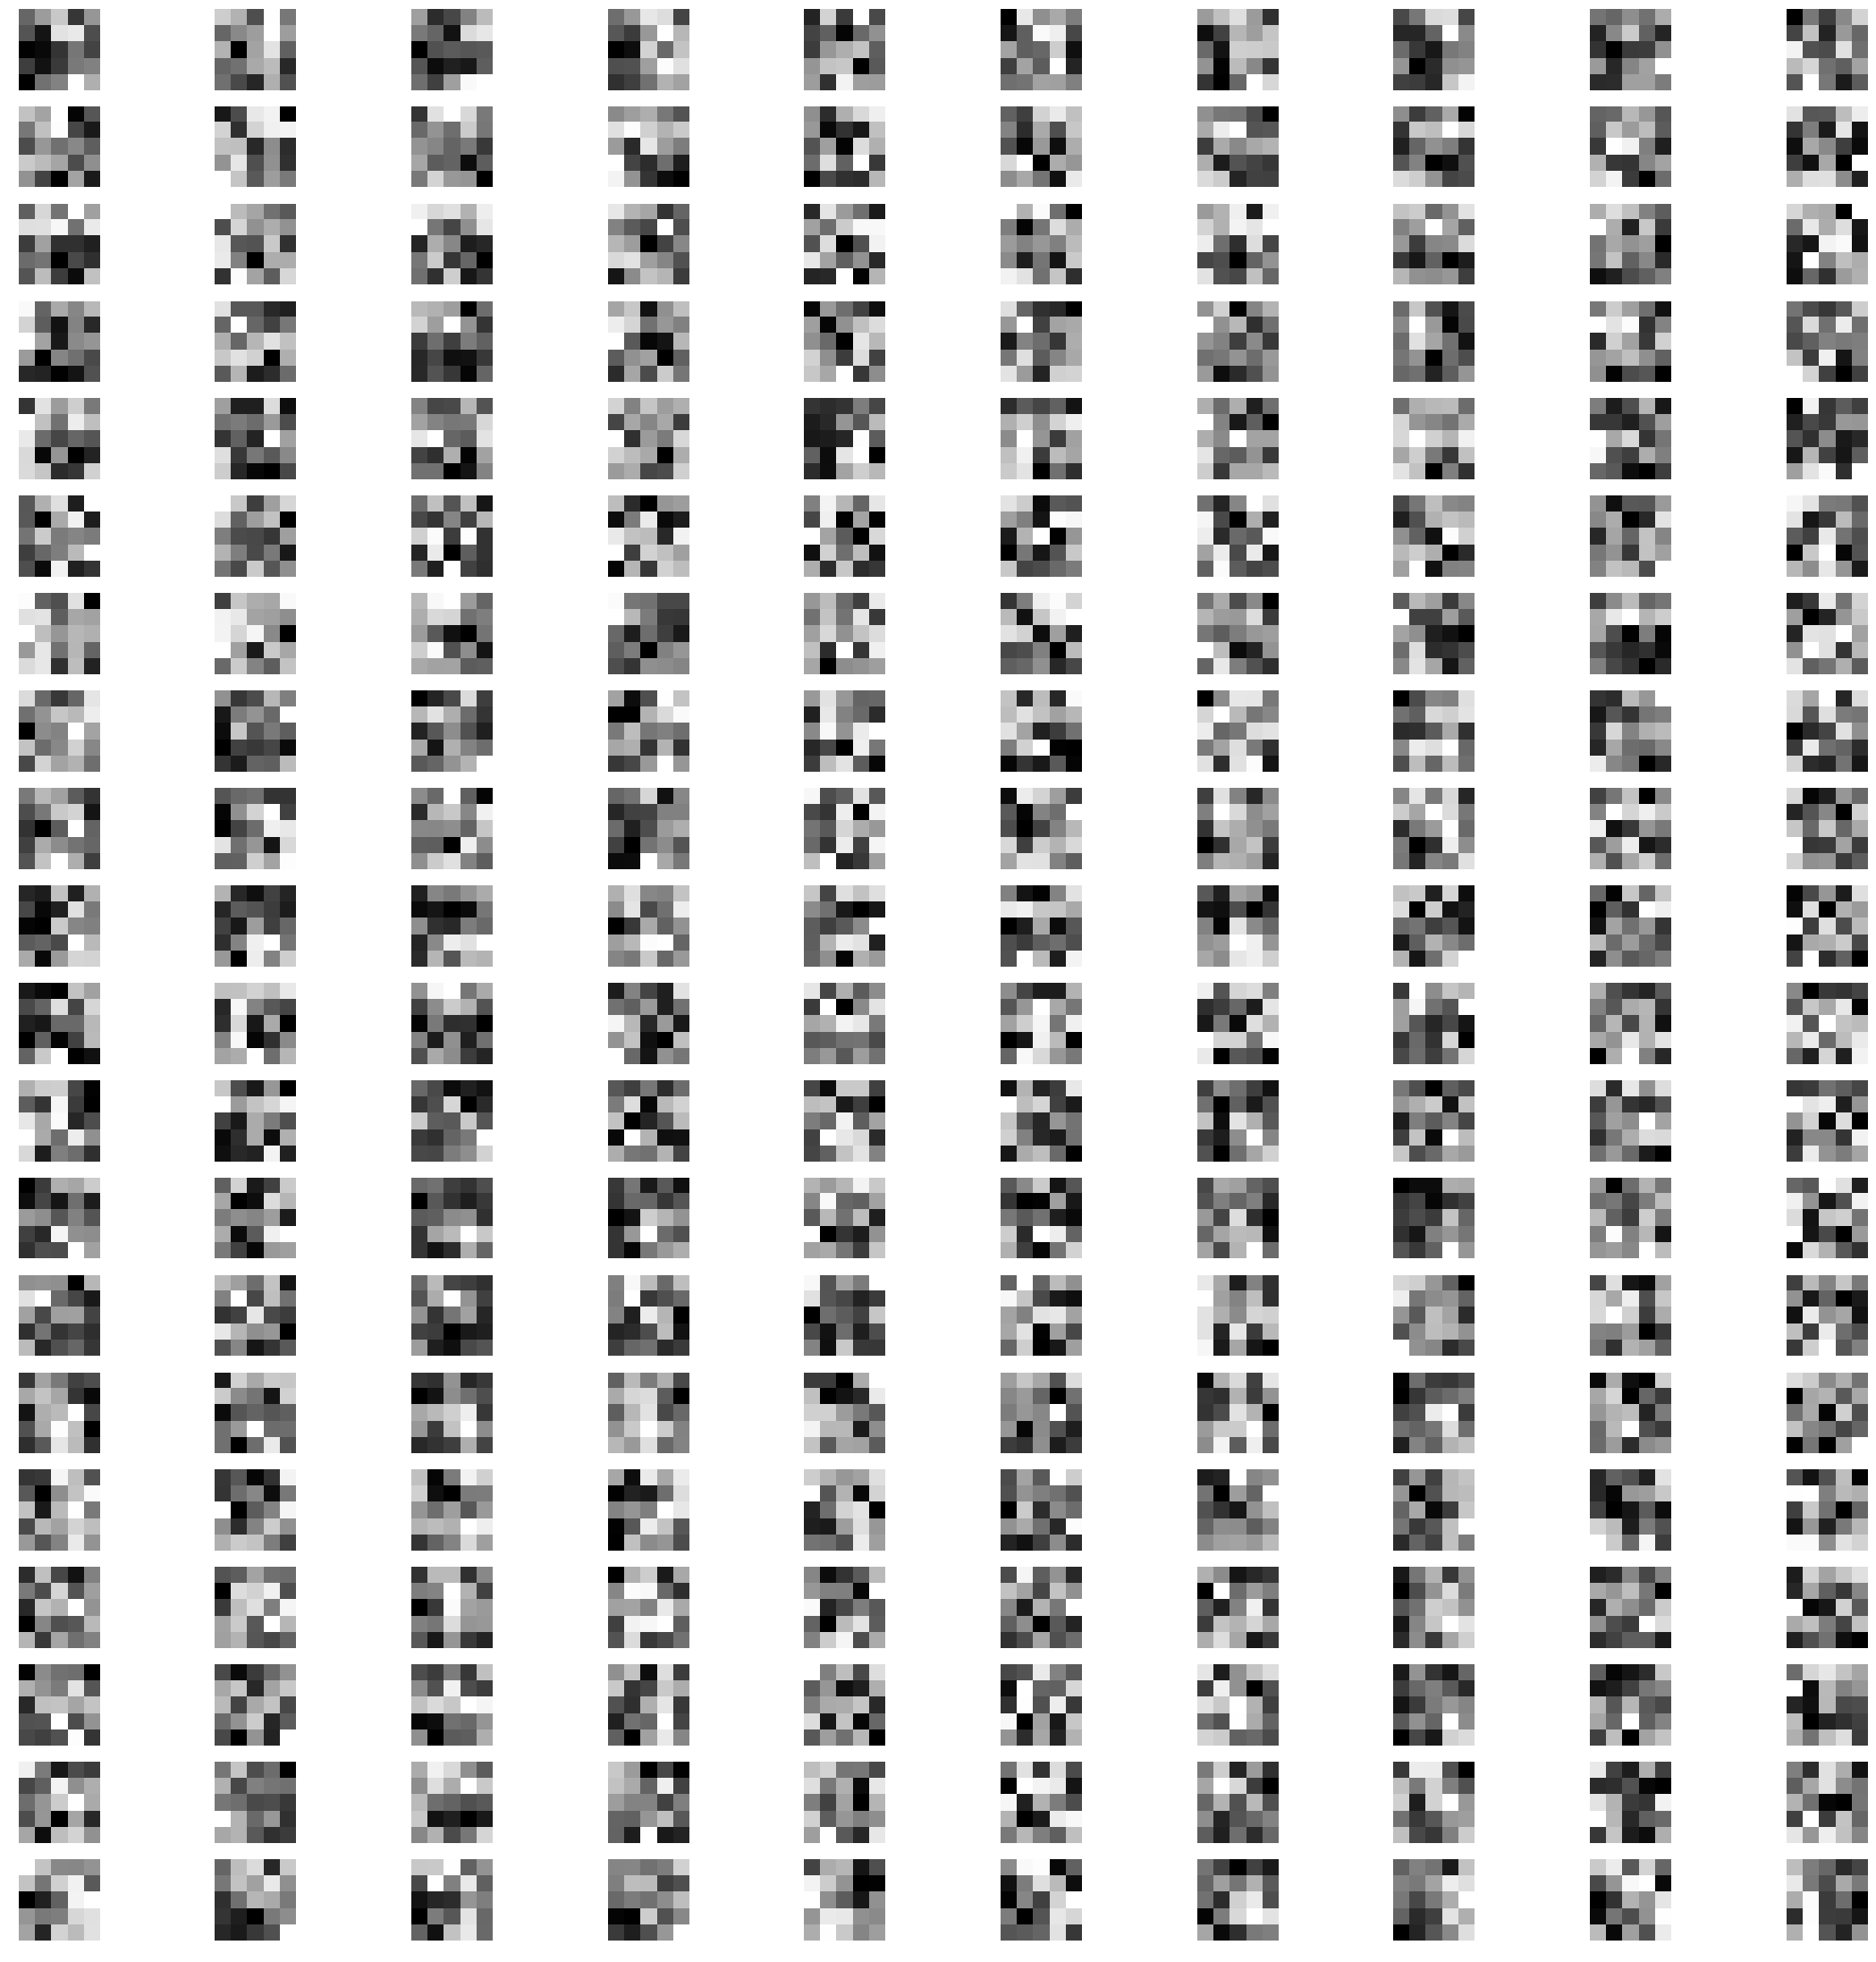

In [28]:
kernels = model_90.conv2.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv2_weights_90.png')

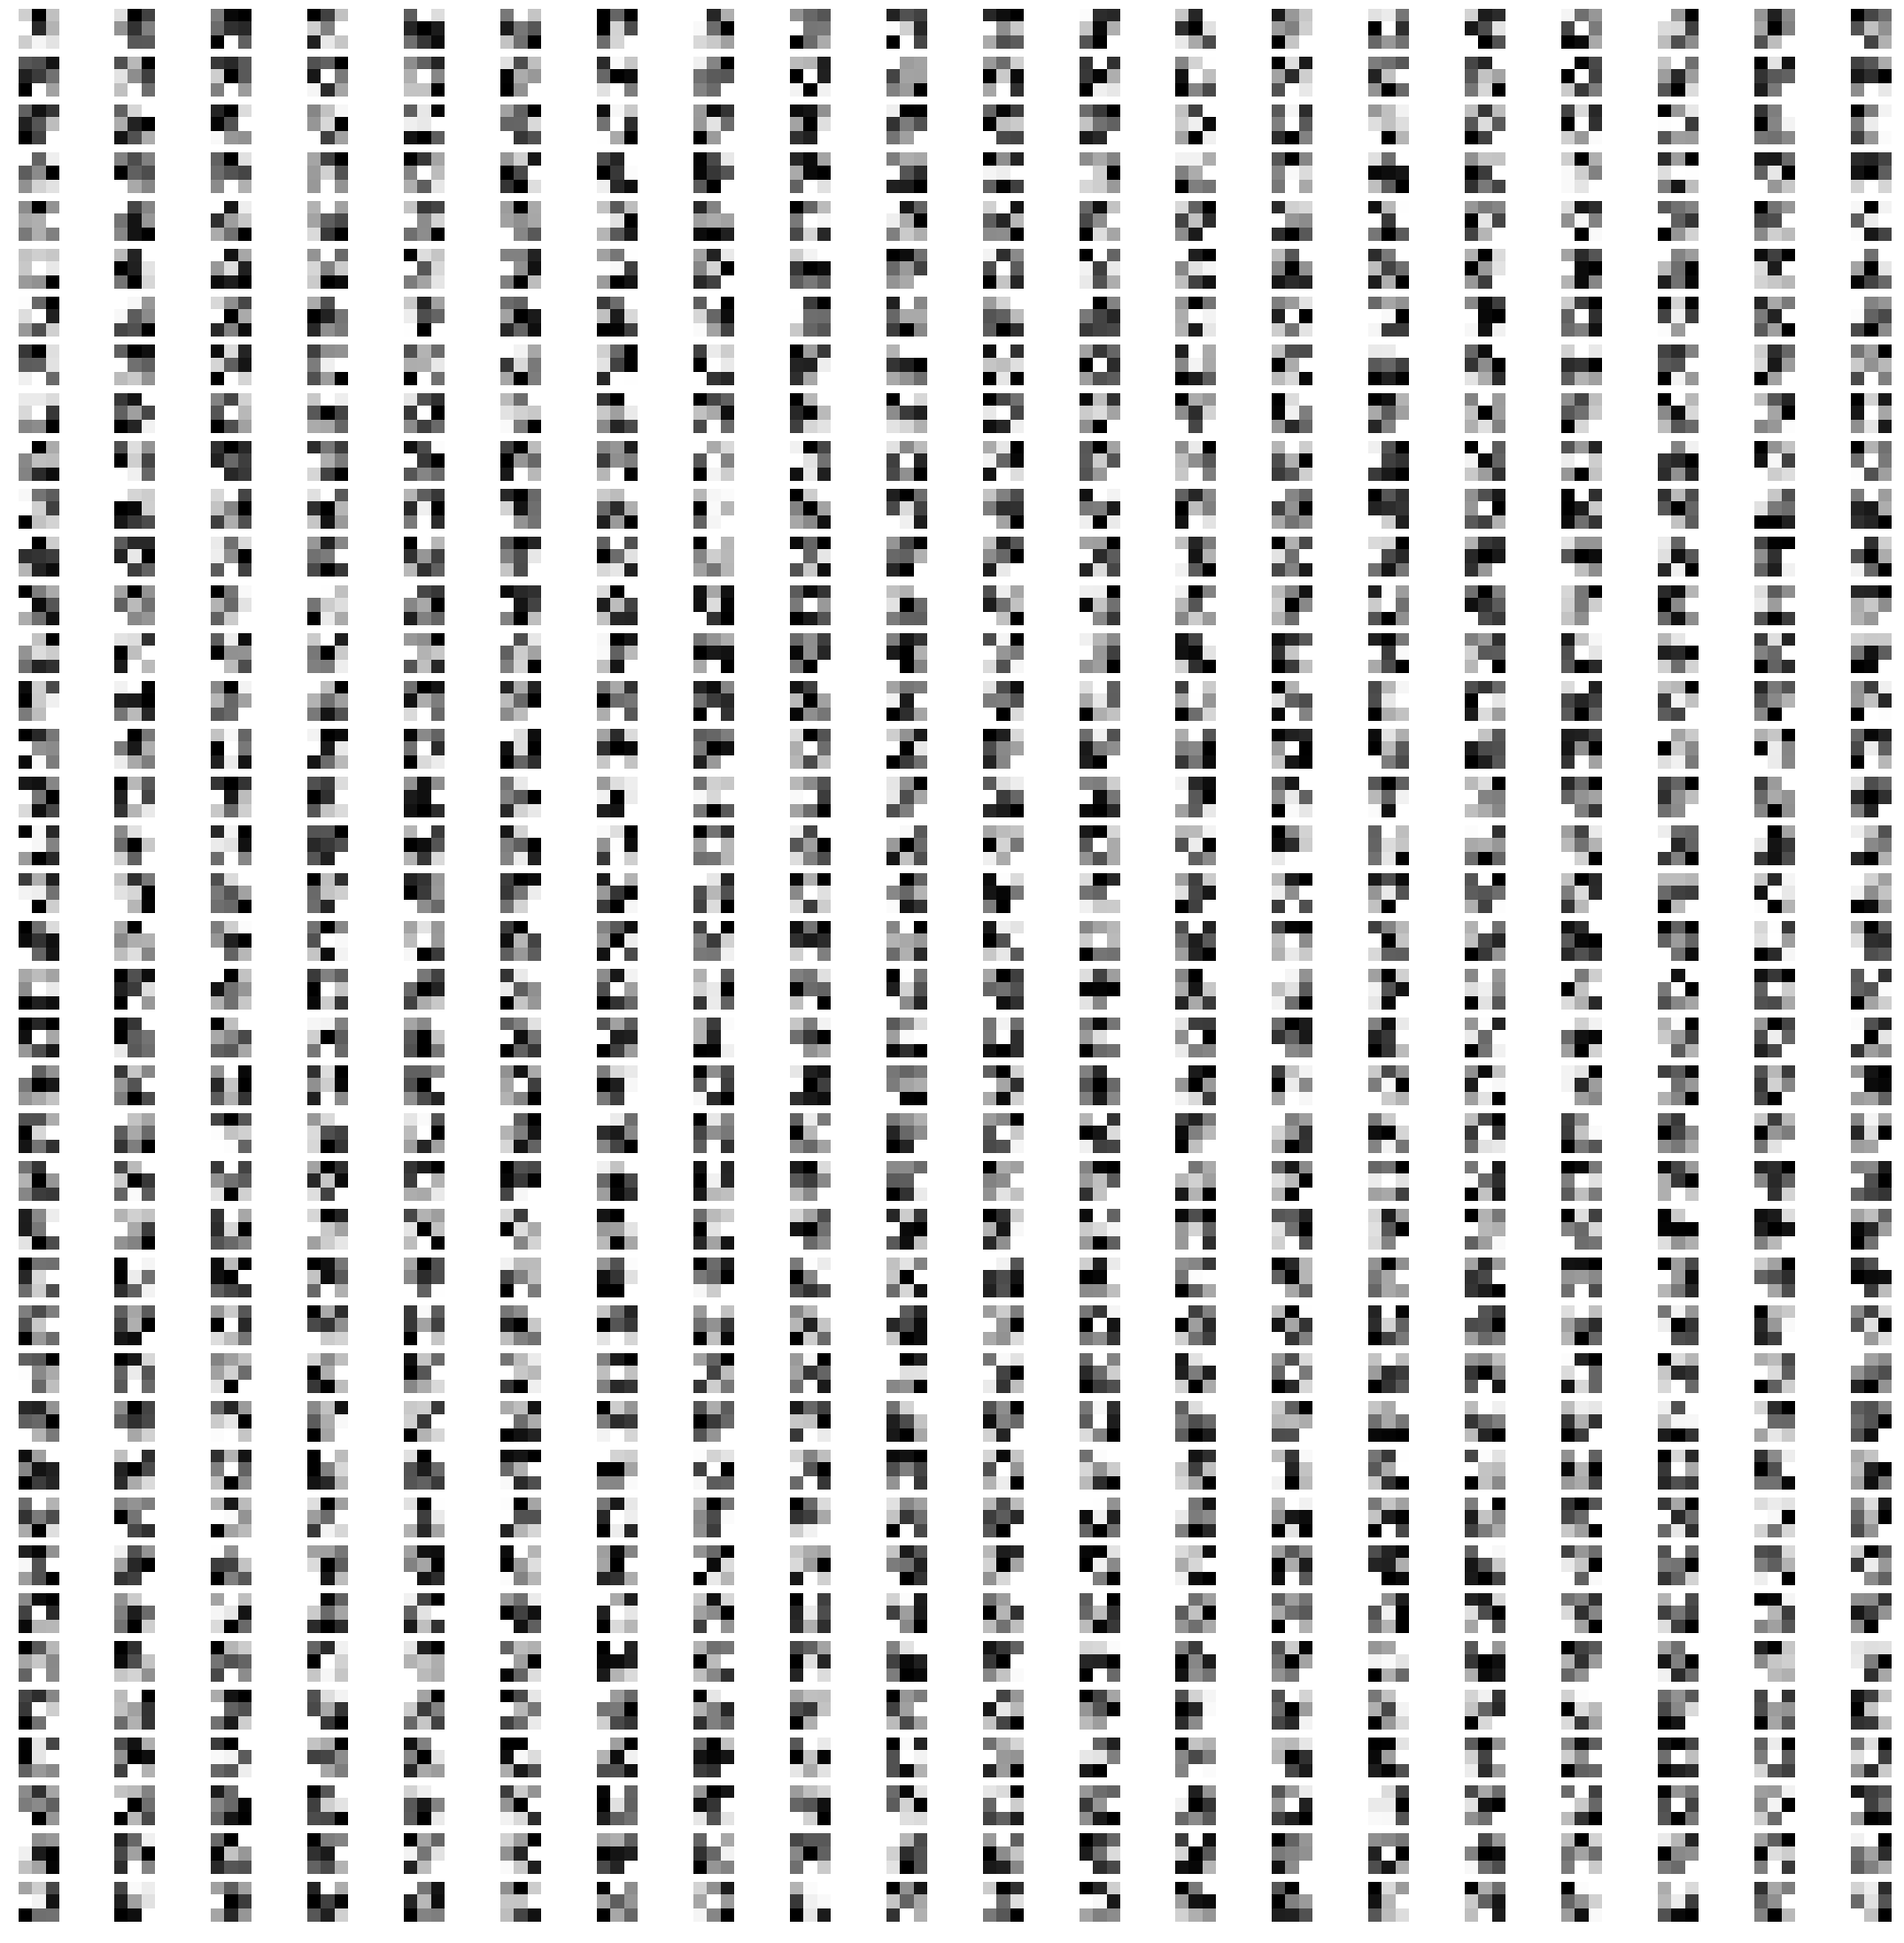

In [29]:
kernels = model_90.conv3.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv3_weights_90.png')

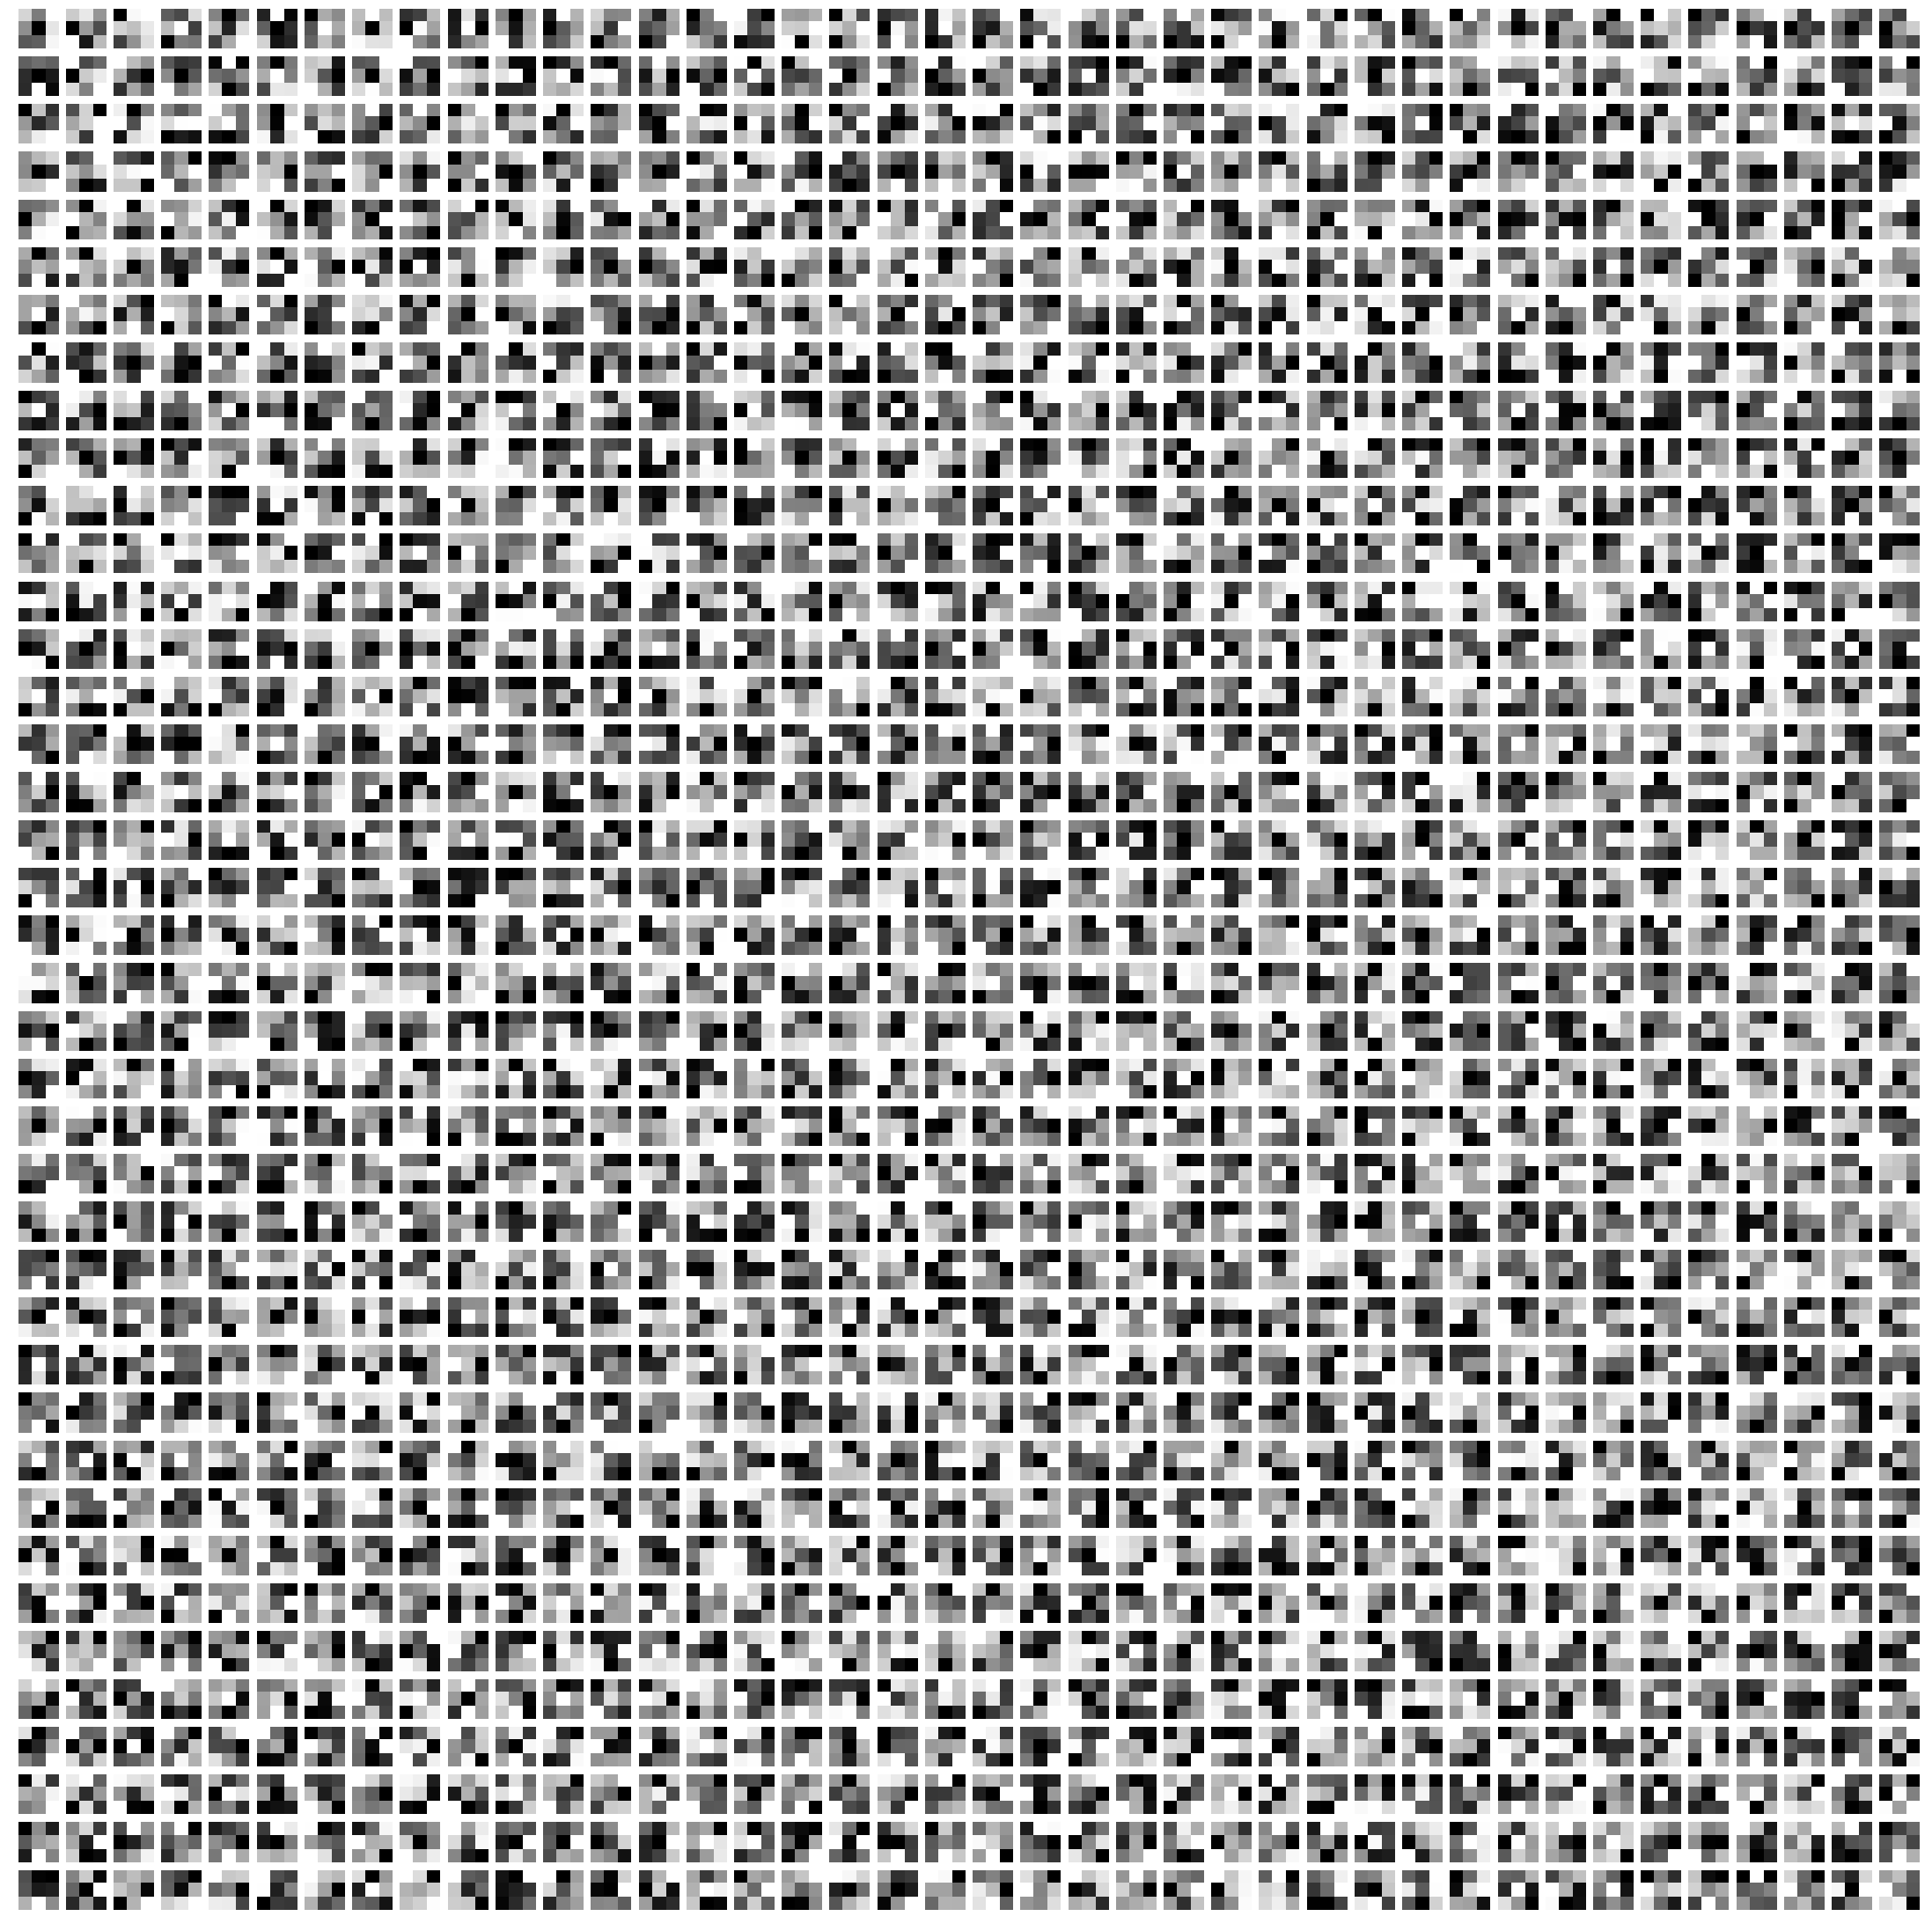

In [30]:
kernels = model.conv4.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'results/conv4_weights_90.png')

#### Activation Visualization

In [31]:
print("Predicted Class: ", 
      np.argmax(model_90.forward(number_90.cuda()).cpu().detach().numpy()))

Predicted Class:  0


We see that the prediction itself is wrong! Why?

#### CNN Layer 1

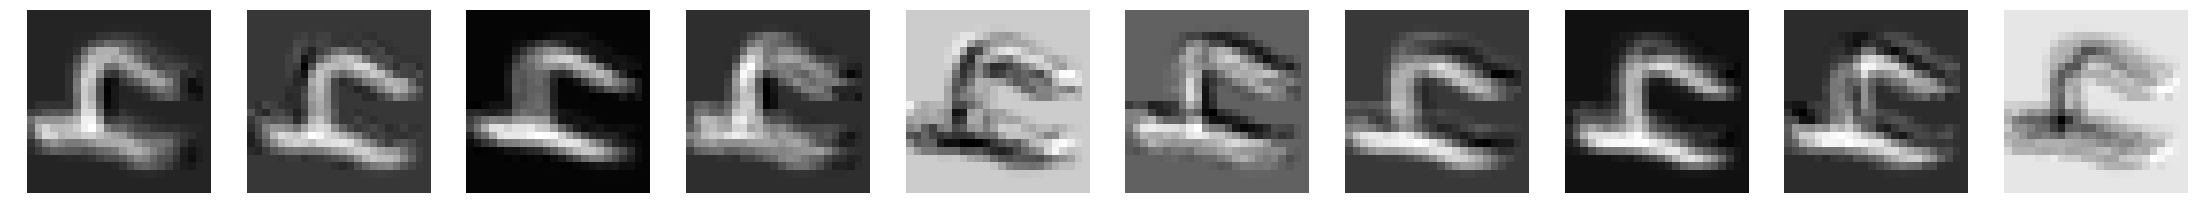

In [32]:
conv1_out_90 = model_90.conv1.forward(number_90.cuda())
custom_viz(conv1_out_90.cpu().detach().clone(), 'results/conv1_actv_90.png')

#### CNN Layer 2

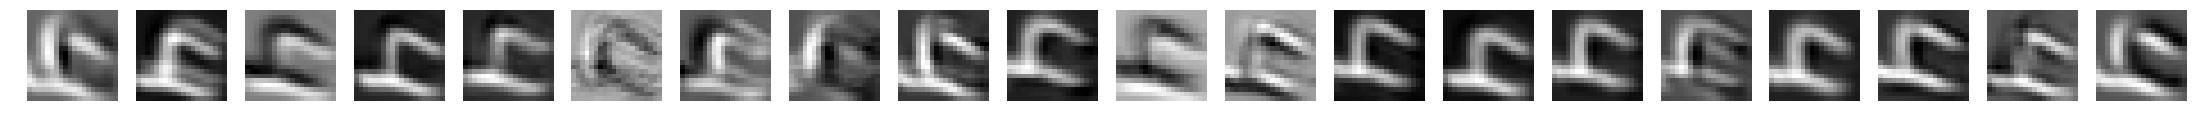

In [33]:
conv2_out_90 = model_90.conv2.forward(conv1_out_90.cuda())
custom_viz(conv2_out_90.cpu().detach().clone(), 'results/conv2_actv_90.png')

#### CNN Layer 3

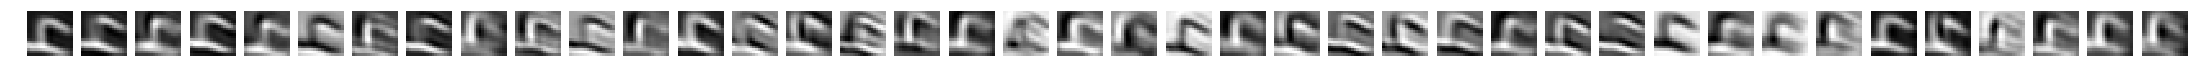

In [34]:
conv3_out_90 = model_90.conv3.forward(conv2_out_90.cuda())
custom_viz(conv3_out_90.cpu().detach().clone(), 'results/conv3_actv_90.png')

#### CNN Layer 4

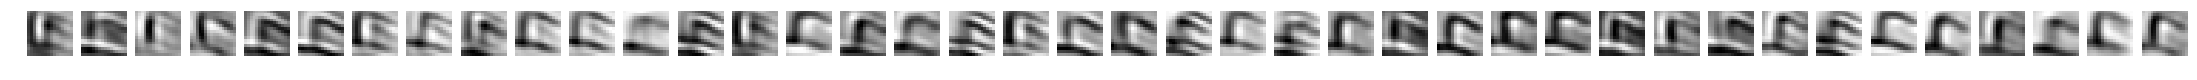

In [35]:
conv4_out_90 = model_90.conv4.forward(conv3_out_90.cuda())
custom_viz(conv4_out_90.cpu().detach().clone(), 'results/conv4_actv_90.png')

# Questions for part 2

    1. What happens if I try to evaluate `model` with 90 rotated MNIST, 
       and `model_90` with normal MNIST? Will I see a drop in accuracy?
    2. What does the activations show? Are the features look similar?
    3. What do you understand from the weight matrices? Can you come 
       to a conclusion based on them?
    4. Why do you think the model predicted wrongly?
    5. Come up with an architecture that can learn rotated MNIST properly.
    6. What are the relationships, think.., think!